# Yen Wei Loh: Capstone Project for DSI

# Executive summary:

### The overarching goal of this Capstone is to reduce overdoses caused by prescribed, legal opioid medication. Three datasets were obtained from Kaggle.com (https://www.kaggle.com/apryor6/us-opiate-prescriptions) which contain data for opiate overdoses in every state in America, as well as information on 25,000 prescribers in each state, their specialty, gender and individual prescriptions for 250 prescription medications (including opioids). Also included is a dataset listing generic and brand names for opioid medications.

### To achieve the overarching goal, I planned my approach in three iterative steps. First, I built a model to predict Opioid Prescribers with an accuracy of at least 70%. Then, I built a model to predict the total opiate prescription of a prescriber, with an accuracy of at least 70%. Finally, I used the Residual Error between the predicted opiate prescription and true opiate prescription to identify the candidates with the most suspicious prescription rates.

### It should be noted that a large challenge in identifying fraudulent opiate prescription with this data is that there is no way to identify true or false positives. Thus, the candidates identified by outlier detection are merely suspects that should be investigated further, and may very likely be innocent. (Don't arrest anyone just yet...)

### I used logistic regression and decision tree classifiers to predict Opioid Prescribers, using non-opiate prescriptions, state, specialty and gender. Decision tree classifiers edges out logistic regression, with the respective scores being 78% and 76.8% respectively. 

### Now that I've established that non-opiate prescriptions, state, specialty and gender can be used to predict an Opioid Prescriber, time to move on to Opiate Prescription

### I used linear regression, decision tree regression, and PCA to predict the total opiate prescriptions for a prescriber, based off his/her non-opiate prescriptions, state and specialty. Linear regression was by far the best model, with an accuracy of 79%. (decision tree and PCA had an accuracy of 0.56% and -2.36 respectively

### Finally, I identified the 10 candidates whose true opiate prescription were furthest above the predicted opiate prescription, and flag them as the 10 highest priority candidates for further investigation.

# 1. Import modules

In [78]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import plotly.figure_factory as ff
import plotly.plotly as py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

## 1.1 Read in data

In [79]:
# bring datasets in as dataframes
opioids = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/opioids.csv')
overdoses = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/overdoses.csv')
prescribers = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/prescriber-info.csv')

In [80]:
# now let's have a look
print(opioids.shape)
print(overdoses.shape)
print(prescribers.shape)

(113, 2)
(50, 4)
(25000, 256)


In [81]:
opioids.head(3)

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE


In [82]:
opioids.dtypes

Drug Name       object
Generic Name    object
dtype: object

In [83]:
overdoses.head(3)

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ


In [84]:
overdoses.dtypes

State         object
Population    object
Deaths        object
Abbrev        object
dtype: object

In [85]:
prescribers.head(3)

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0


In [86]:
prescribers.dtypes

NPI                                int64
Gender                            object
State                             object
Credentials                       object
Specialty                         object
ABILIFY                            int64
ACETAMINOPHEN.CODEINE              int64
ACYCLOVIR                          int64
ADVAIR.DISKUS                      int64
AGGRENOX                           int64
ALENDRONATE.SODIUM                 int64
ALLOPURINOL                        int64
ALPRAZOLAM                         int64
AMIODARONE.HCL                     int64
AMITRIPTYLINE.HCL                  int64
AMLODIPINE.BESYLATE                int64
AMLODIPINE.BESYLATE.BENAZEPRIL     int64
AMOXICILLIN                        int64
AMOX.TR.POTASSIUM.CLAVULANATE      int64
AMPHETAMINE.SALT.COMBO             int64
ATENOLOL                           int64
ATORVASTATIN.CALCIUM               int64
AVODART                            int64
AZITHROMYCIN                       int64
BACLOFEN        

## 1.2 Data Cleaning

### 1.2.1 Cleaning overdoses

In [87]:
# convert population and deaths in overdoses into floats
# boston.DIS = boston.DIS.map(lambda x: float(x.replace(',','.')))
overdoses.Population = overdoses.Population.map(lambda x: float(x.replace(',',''))) 
overdoses.Deaths = overdoses.Deaths.map(lambda x: float(x.replace(',','')))

In [88]:
overdoses.head(2)

,State,Population,Deaths,Abbrev
0,Alabama,4833722.0,723.0,AL
1,Alaska,735132.0,124.0,AK


In [89]:
overdoses.dtypes

State          object
Population    float64
Deaths        float64
Abbrev         object
dtype: object

In [90]:
# checking for nulls
overdoses.isnull().sum()

State         0
Population    0
Deaths        0
Abbrev        0
dtype: int64

### 1.2.2 Cleaning opioids and prescribers

In [91]:
# Check the other two datasets for nulls
print(opioids.isnull().sum())
print(overdoses.isnull().sum())
print(prescribers.isnull().sum())

Drug Name       0
Generic Name    0
dtype: int64
State         0
Population    0
Deaths        0
Abbrev        0
dtype: int64
NPI                                 0
Gender                              0
State                               0
Credentials                       763
Specialty                           0
ABILIFY                             0
ACETAMINOPHEN.CODEINE               0
ACYCLOVIR                           0
ADVAIR.DISKUS                       0
AGGRENOX                            0
ALENDRONATE.SODIUM                  0
ALLOPURINOL                         0
ALPRAZOLAM                          0
AMIODARONE.HCL                      0
AMITRIPTYLINE.HCL                   0
AMLODIPINE.BESYLATE                 0
AMLODIPINE.BESYLATE.BENAZEPRIL      0
AMOXICILLIN                         0
AMOX.TR.POTASSIUM.CLAVULANATE       0
AMPHETAMINE.SALT.COMBO              0
ATENOLOL                            0
ATORVASTATIN.CALCIUM                0
AVODART                             0


In [92]:
# DROP CREDENTIALS COLUMN (not using it)
prescribers.drop('Credentials',axis=1,inplace=True)
print(prescribers.columns)

Index(['NPI', 'Gender', 'State', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       'ALENDRONATE.SODIUM',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=255)


In [93]:
# taking a closer look at opioids
print(opioids.head())
# okay, so the names are messy. There's 'WITH', '-', '/'. I want it all to be replace with '_'

# First, replace the spaces in the column names with _
# using df.rename(columns=lambda x: x.replace('$', ''), inplace=True) from paulo.filip3 on stackoverflow
opioids.rename(columns=lambda x: x.replace(' ','_'),inplace=True)
print(opioids.head(1))

                        Drug Name                    Generic Name
0                         ABSTRAL                FENTANYL CITRATE
1           ACETAMINOPHEN-CODEINE      ACETAMINOPHEN WITH CODEINE
2                           ACTIQ                FENTANYL CITRATE
3             ASCOMP WITH CODEINE  CODEINE/BUTALBITAL/ASA/CAFFEIN
4  ASPIRIN-CAFFEINE-DIHYDROCODEIN  DIHYDROCODEINE/ASPIRIN/CAFFEIN
  Drug_Name      Generic_Name
0   ABSTRAL  FENTANYL CITRATE


In [94]:
# sweet, now we rmake all joiners '_'
#overdoses.Population = overdoses.Population.map(lambda x: float(x.replace(',',''))) 
opioids.Drug_Name = opioids.Drug_Name.map(lambda x: x.replace('/', '_'))
opioids.Drug_Name = opioids.Drug_Name.map(lambda x: x.replace('-', '_'))
opioids.Drug_Name = opioids.Drug_Name.map(lambda x: x.replace(' WITH ', '_'))
opioids.Generic_Name = opioids.Generic_Name.map(lambda x: x.replace('/', '_'))
opioids.Generic_Name = opioids.Generic_Name.map(lambda x: x.replace('-', '_'))
opioids.Generic_Name = opioids.Generic_Name.map(lambda x: x.replace(' WITH ', '_'))

opioids.Drug_Name = opioids.Drug_Name.map(lambda x: x.replace(' ', '_'))
opioids.Generic_Name = opioids.Generic_Name.map(lambda x: x.replace(' ', '_'))
print(opioids.head())

                        Drug_Name                    Generic_Name
0                         ABSTRAL                FENTANYL_CITRATE
1           ACETAMINOPHEN_CODEINE           ACETAMINOPHEN_CODEINE
2                           ACTIQ                FENTANYL_CITRATE
3                  ASCOMP_CODEINE  CODEINE_BUTALBITAL_ASA_CAFFEIN
4  ASPIRIN_CAFFEINE_DIHYDROCODEIN  DIHYDROCODEINE_ASPIRIN_CAFFEIN


In [95]:
# Similarly, i want to get rid of the empty spaces in prescribers column names
# First, replace '.' with '_' across the entire dataframe
# using df.rename(columns=lambda x: x.replace('$', ''), inplace=True) from paulo.filip3 on stackoverflow
prescribers.rename(columns=lambda x: x.replace('.','_'),inplace=True)
print(prescribers.head())

          NPI Gender State            Specialty  ABILIFY  \
0  1710982582      M    TX              Dentist        0   
1  1245278100      F    AL      General Surgery        0   
2  1427182161      F    NY     General Practice        0   
3  1669567541      M    AZ    Internal Medicine        0   
4  1679650949      M    NV  Hematology/Oncology        0   

   ACETAMINOPHEN_CODEINE  ACYCLOVIR  ADVAIR_DISKUS  AGGRENOX  \
0                      0          0              0         0   
1                      0          0              0         0   
2                      0          0              0         0   
3                     43          0              0         0   
4                      0          0              0         0   

   ALENDRONATE_SODIUM        ...          VERAPAMIL_ER  VESICARE  VOLTAREN  \
0                   0        ...                     0         0         0   
1                   0        ...                     0         0         0   
2                   

In [96]:
# Now to figure out if the drug names in prescribers are generic or brands (If they're brands, i might be 
# in trouble, since I messed with all their names above.)
print(prescribers.columns[:20])
# looks like generic names (Phew!)

Index(['NPI', 'Gender', 'State', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN_CODEINE', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX',
       'ALENDRONATE_SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM', 'AMIODARONE_HCL',
       'AMITRIPTYLINE_HCL', 'AMLODIPINE_BESYLATE',
       'AMLODIPINE_BESYLATE_BENAZEPRIL', 'AMOXICILLIN',
       'AMOX_TR_POTASSIUM_CLAVULANATE', 'AMPHETAMINE_SALT_COMBO', 'ATENOLOL'],
      dtype='object')


In [97]:
# now count number of Opioid Prescribers (might be useful later)
print(prescribers.Opioid_Prescriber.value_counts())

1    14688
0    10312
Name: Opioid_Prescriber, dtype: int64


## 1.3 Creating Dummy Variables for prescribers

In [98]:
prescribers.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1


### (1.3) Gender, State, and Specialty are categorical variables that would be easier to analyse if I create dummy variables

In [99]:
# convert gender to numeric. (1 = Male, 2 = Female)
# first, write a function
def gender_to_sex(gender):
    gender = str(gender)
    if gender == 'M':
        gender = 1
    elif gender == 'F':
        gender = 2
    return gender 

In [100]:
prescribers['sex'] = [gender_to_sex(gender) for gender in prescribers['Gender']]

In [101]:
# ok, we can now drop gender
prescribers.drop('Gender', axis=1, inplace=True)

In [102]:
prescribers.head(2)

,NPI,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber,sex
0,1710982582,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,1245278100,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,35,1,2


In [103]:
spec_list = prescribers['Specialty'].tolist()
print(len(spec_list))

25000


In [104]:
# write a function to create dictionary for specialty = '1_' indicates a specialty (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
spec_dict={}
def spec_dummy(specialty):
    for spec in specialty:
        spec_dict[spec]='1_' + spec

In [105]:
spec_dummy(spec_list)
print(len(spec_dict))

109


In [106]:
# Create field with mapped location dictionary
prescribers['spec_val'] = prescribers['Specialty'].map(spec_dict)
prescribers[['Specialty', 'spec_val']].head()

,Specialty,spec_val
0,Dentist,1_Dentist
1,General Surgery,1_General Surgery
2,General Practice,1_General Practice
3,Internal Medicine,1_Internal Medicine
4,Hematology/Oncology,1_Hematology/Oncology


In [107]:
# Create dummies for locations

spec_val_dummies = pd.get_dummies(prescribers['spec_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, spec_val_dummies], axis=1)

prescribers.head()

,NPI,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245278100,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1427182161,NY,General Practice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1669567541,AZ,Internal Medicine,0,43,0,0,0,21,0,...,0,0,0,0,0,0,0,0,0,0
4,1679650949,NV,Hematology/Oncology,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### (1.3) Okay, looks good. now to check states in prescribers. There are 57 unique values in prescriber.State, but only 50 in overdoses.Abbrev. This means to match up prescribers to overdoses, I need to get rid of the 7 extra State values.

In [108]:
print(len(prescribers.State.unique()))

57


In [109]:
overdoses.Abbrev.nunique()

50

In [110]:
# next step, drop prescriber.State rows which do not match overdoses.Abbrev
# first, get list of overdoses.Abbrev
state_list = overdoses['Abbrev'].tolist()
print(state_list)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [111]:
prescribers_state_list = prescribers['State'].tolist()
print(len(prescribers_state_list))

25000


In [112]:
# write a function to drop row if row not found in state_list
drop_state = []
def drop_extra(x_list):
    for state in x_list:
        if state not in state_list:
            drop_state.append(state)
    return drop_state

In [113]:
drop_extra(prescribers_state_list)
print(len(drop_state))

320


In [114]:
from collections import Counter
c = Counter(drop_state)
print(c.items())

dict_items([('PR', 231), ('DC', 79), ('AE', 2), ('ZZ', 2), ('GU', 2), ('AA', 1), ('VI', 3)])


### (1.3) Okay, so we drop these items.

In [115]:
# from ksookall on stack, df = df[~df['your column'].isin(['list of strings'])]
prescribers = prescribers[~prescribers['State'].isin(['PR','DC','AE','ZZ','GU','AA','VT'])]
print(prescribers.State.nunique())

50


### (1.3) This leaves me with 24618 rows in prescribers (Still a pretty good sample size)

In [116]:
prescribers_state = prescribers['State'].tolist()
print(len(prescribers_state))

24618


### (1.3) Okay, now we turn State into dummy variables, just like we did for specialty, except we denote it as '2_'

In [117]:
# write a function to create dictionary for State = '2_' indicates a State (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
state_dict={}
def state_dummy(state):
    for st in state:
        state_dict[st]='2_' + st

In [118]:
state_dummy(prescribers_state)
print(state_dict)

{'TX': '2_TX', 'AL': '2_AL', 'NY': '2_NY', 'AZ': '2_AZ', 'NV': '2_NV', 'PA': '2_PA', 'NH': '2_NH', 'WI': '2_WI', 'CO': '2_CO', 'OH': '2_OH', 'MA': '2_MA', 'CT': '2_CT', 'FL': '2_FL', 'MN': '2_MN', 'UT': '2_UT', 'IA': '2_IA', 'IL': '2_IL', 'MT': '2_MT', 'IN': '2_IN', 'VA': '2_VA', 'CA': '2_CA', 'OR': '2_OR', 'NE': '2_NE', 'MI': '2_MI', 'NM': '2_NM', 'TN': '2_TN', 'KS': '2_KS', 'LA': '2_LA', 'MD': '2_MD', 'MO': '2_MO', 'AR': '2_AR', 'NC': '2_NC', 'NJ': '2_NJ', 'SC': '2_SC', 'WY': '2_WY', 'ME': '2_ME', 'OK': '2_OK', 'ND': '2_ND', 'KY': '2_KY', 'GA': '2_GA', 'DE': '2_DE', 'WA': '2_WA', 'RI': '2_RI', 'WV': '2_WV', 'AK': '2_AK', 'ID': '2_ID', 'HI': '2_HI', 'MS': '2_MS', 'SD': '2_SD', 'VI': '2_VI'}


In [119]:
# Create field with mapped location dictionary
prescribers['state_val'] = prescribers['State'].map(state_dict)
prescribers[['State', 'state_val']].head(2)

,State,state_val
0,TX,2_TX
1,AL,2_AL


In [120]:
# Create dummies for locations

state_val_dummies = pd.get_dummies(prescribers['state_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, state_val_dummies], axis=1)

prescribers.head(2)

,NPI,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,2_SD,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY
0,1710982582,TX,Dentist,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1245278100,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
#prescribers.drop(['State','Specialty'],axis=1,inplace=True) (keeping this in for now, might need later)
prescribers.drop(['state_val','spec_val'],axis=1,inplace=True)

## 1.4 Finding the opiates prescribed.

In [122]:
opioids.Generic_Name.nunique()

37

### (1.4) So there are 37 unique opiates in the opioids dataset. Are all of them represented in the prescribers dataset? Or are there only a small group being prescribed?

In [123]:
# alright, let's get a list of unique opiate generic_names
opiate_list = list(opioids['Generic_Name'].unique())
print(opiate_list)
print(len(opiate_list))

['FENTANYL_CITRATE', 'ACETAMINOPHEN_CODEINE', 'CODEINE_BUTALBITAL_ASA_CAFFEIN', 'DIHYDROCODEINE_ASPIRIN_CAFFEIN', 'MORPHINE_SULFATE', 'OPIUM_BELLADONNA_ALKALOIDS', 'BUPRENORPHINE_HCL', 'BUTALBIT_ACETAMIN_CAFF_CODEINE', 'BUTORPHANOL_TARTRATE', 'BUPRENORPHINE', 'CODEINE_CARISOPRODOL_ASPIRIN', 'CODEINE_SULFATE', 'HYDROCODONE_ACETAMINOPHEN', 'TRAMADOL_HCL', 'MEPERIDINE_HCL', 'MEPERIDINE_HCL_PF', 'HYDROMORPHONE_HCL', 'HYDROMORPHONE_HCL_PF', 'METHADONE_HCL', 'FENTANYL', 'MORPHINE_SULFATE_PF', 'OXYCODONE_HCL_ACETAMINOPHEN', 'OXYCODONE_HCL_ASPIRIN', 'HYDROCODONE_IBUPROFEN', 'LEVORPHANOL_TARTRATE', 'NALBUPHINE_HCL', 'TAPENTADOL_HCL', 'OXYMORPHONE_HCL', 'OPIUM_TINCTURE', 'OXYCODONE_HCL', 'IBUPROFEN_OXYCODONE_HCL', 'PENTAZOCINE_HCL_ACETAMINOPHEN', 'PENTAZOCINE_HCL_NALOXONE_HCL', 'PENTAZOCINE_LACTATE', 'TRAMADOL_HCL_ACETAMINOPHEN', 'DHCODEINE_BT_ACETAMINOPHN_CAFF', 'HYDROCODONE_BITARTRATE']
37


In [124]:
prescribers_column_list = list(prescribers.columns)

In [125]:
# Okay, now let's go through all column names of prescribers, and add a '3_' prefix to indicate opiates
new_columns = []

for item in prescribers_column_list:
    if item in opiate_list:
        item = '3_' + item
        new_columns.append(item)
    else:
        new_columns.append(item)

print(new_columns)

['NPI', 'State', 'Specialty', 'ABILIFY', '3_ACETAMINOPHEN_CODEINE', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX', 'ALENDRONATE_SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM', 'AMIODARONE_HCL', 'AMITRIPTYLINE_HCL', 'AMLODIPINE_BESYLATE', 'AMLODIPINE_BESYLATE_BENAZEPRIL', 'AMOXICILLIN', 'AMOX_TR_POTASSIUM_CLAVULANATE', 'AMPHETAMINE_SALT_COMBO', 'ATENOLOL', 'ATORVASTATIN_CALCIUM', 'AVODART', 'AZITHROMYCIN', 'BACLOFEN', 'BD_ULTRA_FINE_PEN_NEEDLE', 'BENAZEPRIL_HCL', 'BENICAR', 'BENICAR_HCT', 'BENZTROPINE_MESYLATE', 'BISOPROLOL_HYDROCHLOROTHIAZIDE', 'BRIMONIDINE_TARTRATE', 'BUMETANIDE', 'BUPROPION_HCL_SR', 'BUPROPION_XL', 'BUSPIRONE_HCL', 'BYSTOLIC', 'CARBAMAZEPINE', 'CARBIDOPA_LEVODOPA', 'CARISOPRODOL', 'CARTIA_XT', 'CARVEDILOL', 'CEFUROXIME', 'CELEBREX', 'CEPHALEXIN', 'CHLORHEXIDINE_GLUCONATE', 'CHLORTHALIDONE', 'CILOSTAZOL', 'CIPROFLOXACIN_HCL', 'CITALOPRAM_HBR', 'CLINDAMYCIN_HCL', 'CLOBETASOL_PROPIONATE', 'CLONAZEPAM', 'CLONIDINE_HCL', 'CLOPIDOGREL', 'CLOTRIMAZOLE_BETAMETHASONE', 'COLCRYS', 'COMBIVENT

In [126]:
prescribers.columns = new_columns

In [127]:
# show me all columns that start with '3'
# from acidtobi on stack: cols = [x for x in my_df.columns if start <= x <= stop]
opiate_columns = [c for c in prescribers.columns if c[0] =='3']
opiate_columns

['3_ACETAMINOPHEN_CODEINE',
 '3_FENTANYL',
 '3_HYDROCODONE_ACETAMINOPHEN',
 '3_HYDROMORPHONE_HCL',
 '3_METHADONE_HCL',
 '3_MORPHINE_SULFATE',
 '3_OXYCODONE_HCL',
 '3_TRAMADOL_HCL']

### (1.4) Well, it looks like there are only 8 opiates being prescribed by the prescribers in my dataset. Lets sum the opiate and non-opiate prescriptions

### Note: Oxycodone_Acetaminophen, Morphine_Sulfate_ER and Oxycontin are opioids that got through my initial filter. I caught it when I was doing logistic regression with non-opiates, and have gone back in my code to fix the errors

In [128]:
total_prescribers = prescribers.columns.tolist()

norm_drugs = []
for c in total_prescribers:
    if c[0].isdigit():
        pass
    elif c == 'sex':
        pass
    elif c == 'Opioid_Prescriber':
        pass
    elif c == 'NPI':
        pass
    elif c == 'State':
        pass
    elif c == 'Specialty':
        pass
    elif c == 'OXYCODONE_ACETAMINOPHEN':
        pass
    elif c == 'MORPHINE_SULFATE_ER':
        pass
    elif c == 'OXYCONTIN':
        pass
    else:
        norm_drugs.append(c)
print(norm_drugs)

['ABILIFY', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX', 'ALENDRONATE_SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM', 'AMIODARONE_HCL', 'AMITRIPTYLINE_HCL', 'AMLODIPINE_BESYLATE', 'AMLODIPINE_BESYLATE_BENAZEPRIL', 'AMOXICILLIN', 'AMOX_TR_POTASSIUM_CLAVULANATE', 'AMPHETAMINE_SALT_COMBO', 'ATENOLOL', 'ATORVASTATIN_CALCIUM', 'AVODART', 'AZITHROMYCIN', 'BACLOFEN', 'BD_ULTRA_FINE_PEN_NEEDLE', 'BENAZEPRIL_HCL', 'BENICAR', 'BENICAR_HCT', 'BENZTROPINE_MESYLATE', 'BISOPROLOL_HYDROCHLOROTHIAZIDE', 'BRIMONIDINE_TARTRATE', 'BUMETANIDE', 'BUPROPION_HCL_SR', 'BUPROPION_XL', 'BUSPIRONE_HCL', 'BYSTOLIC', 'CARBAMAZEPINE', 'CARBIDOPA_LEVODOPA', 'CARISOPRODOL', 'CARTIA_XT', 'CARVEDILOL', 'CEFUROXIME', 'CELEBREX', 'CEPHALEXIN', 'CHLORHEXIDINE_GLUCONATE', 'CHLORTHALIDONE', 'CILOSTAZOL', 'CIPROFLOXACIN_HCL', 'CITALOPRAM_HBR', 'CLINDAMYCIN_HCL', 'CLOBETASOL_PROPIONATE', 'CLONAZEPAM', 'CLONIDINE_HCL', 'CLOPIDOGREL', 'CLOTRIMAZOLE_BETAMETHASONE', 'COLCRYS', 'COMBIVENT_RESPIMAT', 'CRESTOR', 'CYCLOBENZAPRINE_HCL', 'DEXILANT'

In [129]:
prescribers['non-opiates'] = prescribers[norm_drugs].sum(axis=1)
prescribers.head(2)

,NPI,State,Specialty,ABILIFY,3_ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY,non-opiates
0,1710982582,TX,Dentist,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,12
1,1245278100,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1056


### (1.4) Let's now drop the non-opiate prescriptions because there are a lot of them, and it's cluttering my dataframe

In [130]:
# iterate through norm_drugs, dropping every non-opiate.

for item in norm_drugs:
    prescribers.drop(item, axis=1, inplace=True)

### (1.4) And let's sum the opiate prescriptions

### Note: Oxycodone_Acetaminophen, Morphine_Sulfate_ER and Oxycontin are opioids that got through my initial filter. I caught it when I was doing logistic regression with non-opiates, and have gone back in my code to fix the errors

In [131]:
total_prescribers = prescribers.columns.tolist()

opiates = []
for item in total_prescribers:
    if item[0] == str(3):
        opiates.append(item)
opiates.append('OXYCODONE_ACETAMINOPHEN')
opiates.append('MORPHINE_SULFATE_ER')
opiates.append('OXYCONTIN')
opiates

['3_ACETAMINOPHEN_CODEINE',
 '3_FENTANYL',
 '3_HYDROCODONE_ACETAMINOPHEN',
 '3_HYDROMORPHONE_HCL',
 '3_METHADONE_HCL',
 '3_MORPHINE_SULFATE',
 '3_OXYCODONE_HCL',
 '3_TRAMADOL_HCL',
 'OXYCODONE_ACETAMINOPHEN',
 'MORPHINE_SULFATE_ER',
 'OXYCONTIN']

In [132]:
prescribers['opiates'] = prescribers[opiates].sum(axis=1)
prescribers.head(2)

,NPI,State,Specialty,3_ACETAMINOPHEN_CODEINE,3_FENTANYL,3_HYDROCODONE_ACETAMINOPHEN,3_HYDROMORPHONE_HCL,3_METHADONE_HCL,3_MORPHINE_SULFATE,MORPHINE_SULFATE_ER,...,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY,non-opiates,opiates
0,1710982582,TX,Dentist,0,0,17,0,0,0,0,...,1,0,0,0,0,0,0,0,12,17
1,1245278100,AL,General Surgery,0,0,182,0,0,0,24,...,0,0,0,0,0,0,0,0,1056,362


## 1.5 Pull out Opiate Prescribers

In [133]:
# Let's make a prescribers dataframe of only opioid prescribers
druggies = prescribers[prescribers.Opioid_Prescriber == 1]
druggies.head(2)

,NPI,State,Specialty,3_ACETAMINOPHEN_CODEINE,3_FENTANYL,3_HYDROCODONE_ACETAMINOPHEN,3_HYDROMORPHONE_HCL,3_METHADONE_HCL,3_MORPHINE_SULFATE,MORPHINE_SULFATE_ER,...,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY,non-opiates,opiates
0,1710982582,TX,Dentist,0,0,17,0,0,0,0,...,1,0,0,0,0,0,0,0,12,17
1,1245278100,AL,General Surgery,0,0,182,0,0,0,24,...,0,0,0,0,0,0,0,0,1056,362


In [134]:
# Let's save all the cleaned data to a csv
druggies.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/druggies.csv')
opioids.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/clean_opioids.csv')
prescribers.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/clean_prescribers.csv')
overdoses.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/clean_overdoses.csv')

# 2. EDA

### I aim to reduce opiate overdoses by identifying fraudlent opiate prescription by prescribers. However, I must first determine if there is a correlation between opiate prescriptions and opiate overdoses.

In [135]:
# Let's sum opiate prescriptions by state
state_list = overdoses.Abbrev.tolist()
print(state_list)

['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']


In [136]:
opiate_state = {}
for item in state_list:
    opiate_state[item]= prescribers.ix[prescribers['State']==item]['opiates'].sum()
print(opiate_state)

{'AL': 61359, 'AK': 1256, 'AZ': 52710, 'AR': 30821, 'CA': 194150, 'CO': 24328, 'CT': 13309, 'DE': 5527, 'FL': 152171, 'GA': 74877, 'HI': 3345, 'ID': 12090, 'IL': 68449, 'IN': 70749, 'IA': 19254, 'KS': 22846, 'KY': 40713, 'LA': 60407, 'ME': 11590, 'MD': 32508, 'MA': 39993, 'MI': 87660, 'MN': 28611, 'MS': 29753, 'MO': 48824, 'MT': 7155, 'NE': 10105, 'NV': 19877, 'NH': 4832, 'NJ': 29848, 'NM': 9880, 'NY': 79231, 'NC': 90744, 'ND': 4930, 'OH': 90661, 'OK': 34678, 'OR': 29770, 'PA': 100362, 'RI': 7251, 'SC': 40430, 'SD': 6171, 'TN': 75963, 'TX': 130529, 'UT': 10794, 'VT': 0, 'VA': 43841, 'WA': 44599, 'WV': 19743, 'WI': 41173, 'WY': 4624}


In [137]:
state_sumpres = pd.DataFrame(list(opiate_state.items()), columns=['Abbrev','total_prescription'])
state_sumpres.head(4)

,Abbrev,total_prescription
0,AL,61359
1,AK,1256
2,AZ,52710
3,AR,30821


In [138]:
overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,4833722.0,723.0,AL
1,Alaska,735132.0,124.0,AK
2,Arizona,6626624.0,1211.0,AZ
3,Arkansas,2959373.0,356.0,AR
4,California,38332521.0,4521.0,CA


In [139]:
# Let's inner join state_sumpres to overdoses
overdoses = pd.merge(overdoses,state_sumpres, on='Abbrev',how='left')

In [140]:
overdoses.head()

,State,Population,Deaths,Abbrev,total_prescription
0,Alabama,4833722.0,723.0,AL,61359
1,Alaska,735132.0,124.0,AK,1256
2,Arizona,6626624.0,1211.0,AZ,52710
3,Arkansas,2959373.0,356.0,AR,30821
4,California,38332521.0,4521.0,CA,194150


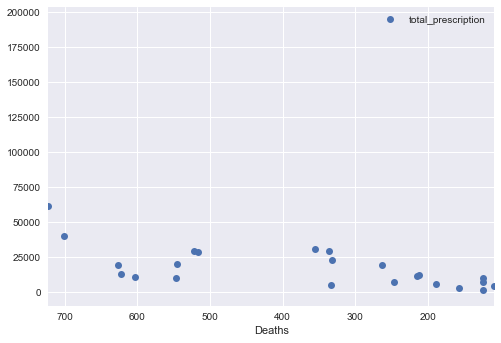

In [141]:
overdoses.plot(x='Deaths',y='total_prescription', style='o')
plt.show()

In [142]:
death_opiate = overdoses['Deaths'].corr(overdoses['total_prescription'])
print(death_opiate)

0.935406235028


### Nice! I've shown a strong correlation between total opiate prescription and overdoses caused by opiates. The image below visualizes that correlation. In the top left chart, deaths by overdose are marked red, with opiates being brown, and the number of overdoses per 10k people in that state is in blue.

### Interestingly, while the total opiate prescription in that state is highly correlated to deaths by overdose, the overdose/population ratio is not. This suggests something about the demographic in each state affecting the likelihood of opiate abuse.

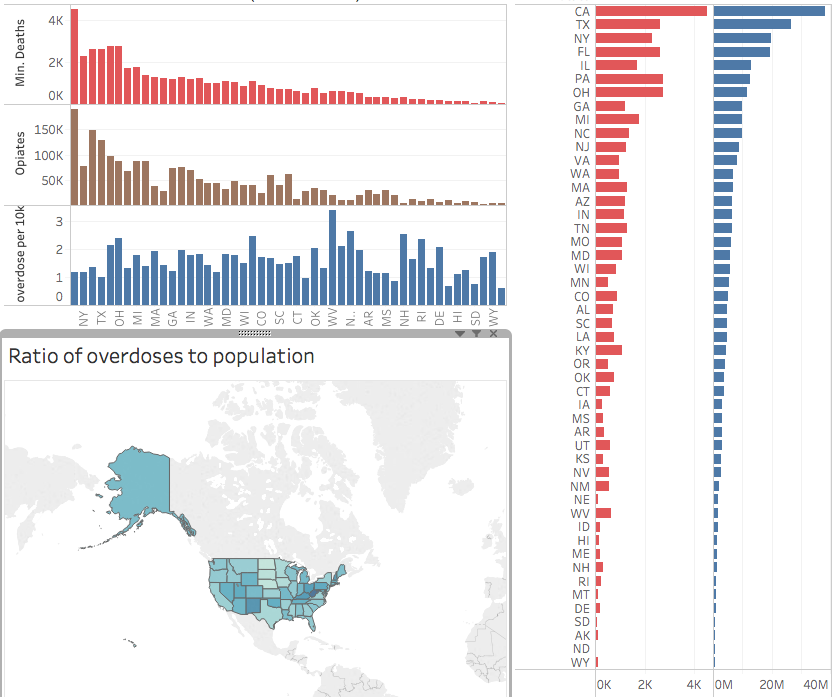

In [143]:
PATH = "/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/"
Image(filename = PATH + "opiates_vs_overdoses.png", width=900, height=900)

## Out of curiosity, do all 11 of the opiates prescribed carry the same correlation?

### Note: Oxycodone_Acetaminophen, Morphine_Sulfate_ER and Oxycontin are opioids that got through my initial filter. I caught it when I was doing logistic regression with non-opiates, and have gone back in my code to fix the errors

In [144]:
# get me a list of opiates
opiates = []
for col in prescribers.columns:
    if col[0] == '3':
        opiates.append(col)
opiates.append('OXYCODONE_ACETAMINOPHEN')
opiates.append('MORPHINE_SULFATE_ER')
opiates.append('OXYCONTIN')
opiates

['3_ACETAMINOPHEN_CODEINE',
 '3_FENTANYL',
 '3_HYDROCODONE_ACETAMINOPHEN',
 '3_HYDROMORPHONE_HCL',
 '3_METHADONE_HCL',
 '3_MORPHINE_SULFATE',
 '3_OXYCODONE_HCL',
 '3_TRAMADOL_HCL',
 'OXYCODONE_ACETAMINOPHEN',
 'MORPHINE_SULFATE_ER',
 'OXYCONTIN']

In [145]:
## So, I want a dataframe that holds the total prescriptions for each opiate, organised by state.
## write a function that takes a list of opiates as argument, and returns a dicitonary with state as keys 
## and sum the opiate as value
def state_opiate_sum(drugs):
    st = {}
    op = []
    for state in state_list:
        #for drug in drugs:
            op_1 = prescribers.ix[prescribers['State']==state][drugs[0]].sum()
            op_2 = prescribers.ix[prescribers['State']==state][drugs[1]].sum()
            op_3 = prescribers.ix[prescribers['State']==state][drugs[2]].sum()
            op_4 = prescribers.ix[prescribers['State']==state][drugs[3]].sum()
            op_5 = prescribers.ix[prescribers['State']==state][drugs[4]].sum()
            op_6 = prescribers.ix[prescribers['State']==state][drugs[5]].sum()
            op_7 = prescribers.ix[prescribers['State']==state][drugs[6]].sum()
            op_8 = prescribers.ix[prescribers['State']==state][drugs[7]].sum()
            op_9 = prescribers.ix[prescribers['State']==state][drugs[8]].sum()
            op_10 = prescribers.ix[prescribers['State']==state][drugs[9]].sum()
            op_11 = prescribers.ix[prescribers['State']==state][drugs[10]].sum()
            op_12 = state
            st[state] = [op_1,op_2,op_3,op_4,op_5,op_6,op_7,op_8,op_9,op_10,op_11,op_12]
    return st

In [146]:
opiate_by_state = state_opiate_sum(opiates)
print(opiate_by_state)

{'AL': [920, 1738, 34560, 222, 709, 488, 1641, 15264, 4001, 1100, 716, 'AL'], 'AK': [11, 41, 430, 84, 69, 11, 217, 118, 87, 157, 31, 'AK'], 'AZ': [1102, 1436, 16095, 728, 1032, 958, 8526, 7284, 8770, 5101, 1678, 'AZ'], 'AR': [580, 941, 16788, 235, 573, 193, 2065, 5433, 2475, 1174, 364, 'AR'], 'CA': [9133, 5677, 110347, 2996, 4012, 1471, 6748, 30379, 11723, 8313, 3351, 'CA'], 'CO': [478, 874, 8054, 458, 357, 254, 3494, 3974, 3825, 1550, 1010, 'CO'], 'CT': [523, 774, 3124, 348, 101, 159, 2172, 2690, 2429, 342, 647, 'CT'], 'DE': [345, 160, 975, 89, 13, 47, 923, 1474, 997, 374, 130, 'DE'], 'FL': [2917, 6333, 48622, 2860, 4167, 3030, 13500, 31312, 24523, 11353, 3554, 'FL'], 'GA': [1211, 2882, 38168, 555, 454, 345, 3182, 16407, 8647, 2170, 856, 'GA'], 'HI': [203, 78, 1298, 29, 12, 66, 602, 531, 288, 156, 82, 'HI'], 'ID': [121, 827, 6348, 78, 348, 75, 951, 1943, 544, 579, 276, 'ID'], 'IL': [3417, 4273, 39355, 480, 503, 641, 1231, 14144, 1987, 1658, 760, 'IL'], 'IN': [1188, 3396, 37064, 455, 1

In [147]:
# dataframe of each opiate summed by state
opiate_summed_state = pd.DataFrame(list(opiate_by_state.items()), columns=['Abbrev','3_ACETAMINOPHEN_CODEINE'])
opiate_summed_state.head()

,Abbrev,3_ACETAMINOPHEN_CODEINE
0,AL,"[920, 1738, 34560, 222, 709, 488, 1641, 15264,..."
1,AK,"[11, 41, 430, 84, 69, 11, 217, 118, 87, 157, 3..."
2,AZ,"[1102, 1436, 16095, 728, 1032, 958, 8526, 7284..."
3,AR,"[580, 941, 16788, 235, 573, 193, 2065, 5433, 2..."
4,CA,"[9133, 5677, 110347, 2996, 4012, 1471, 6748, 3..."


In [148]:
opiate_summed_state = pd.DataFrame(opiate_by_state)
opiate_summed_state = opiate_summed_state.transpose()
opiate_summed_state.columns = opiates + ['Abbrev']
opiate_summed_state.head()

,3_ACETAMINOPHEN_CODEINE,3_FENTANYL,3_HYDROCODONE_ACETAMINOPHEN,3_HYDROMORPHONE_HCL,3_METHADONE_HCL,3_MORPHINE_SULFATE,3_OXYCODONE_HCL,3_TRAMADOL_HCL,OXYCODONE_ACETAMINOPHEN,MORPHINE_SULFATE_ER,OXYCONTIN,Abbrev
AK,11,41,430,84,69,11,217,118,87,157,31,AK
AL,920,1738,34560,222,709,488,1641,15264,4001,1100,716,AL
AR,580,941,16788,235,573,193,2065,5433,2475,1174,364,AR
AZ,1102,1436,16095,728,1032,958,8526,7284,8770,5101,1678,AZ
CA,9133,5677,110347,2996,4012,1471,6748,30379,11723,8313,3351,CA


In [149]:
# sweet. Let's join that to overdoses, using the state.
overdoses = pd.merge(overdoses,opiate_summed_state, on='Abbrev',how='left')
overdoses.dtypes

State                           object
Population                     float64
Deaths                         float64
Abbrev                          object
total_prescription               int64
3_ACETAMINOPHEN_CODEINE         object
3_FENTANYL                      object
3_HYDROCODONE_ACETAMINOPHEN     object
3_HYDROMORPHONE_HCL             object
3_METHADONE_HCL                 object
3_MORPHINE_SULFATE              object
3_OXYCODONE_HCL                 object
3_TRAMADOL_HCL                  object
OXYCODONE_ACETAMINOPHEN         object
MORPHINE_SULFATE_ER             object
OXYCONTIN                       object
dtype: object

In [150]:
overdoses[opiates] = overdoses[opiates].apply(pd.to_numeric)
overdoses.dtypes

State                           object
Population                     float64
Deaths                         float64
Abbrev                          object
total_prescription               int64
3_ACETAMINOPHEN_CODEINE          int64
3_FENTANYL                       int64
3_HYDROCODONE_ACETAMINOPHEN      int64
3_HYDROMORPHONE_HCL              int64
3_METHADONE_HCL                  int64
3_MORPHINE_SULFATE               int64
3_OXYCODONE_HCL                  int64
3_TRAMADOL_HCL                   int64
OXYCODONE_ACETAMINOPHEN          int64
MORPHINE_SULFATE_ER              int64
OXYCONTIN                        int64
dtype: object

In [151]:
# let's look at correlations between each opiate and deaths
op1 = overdoses['Deaths'].corr(overdoses['3_ACETAMINOPHEN_CODEINE'])
op2 = overdoses['Deaths'].corr(overdoses['3_FENTANYL'])
op3 = overdoses['Deaths'].corr(overdoses['3_HYDROCODONE_ACETAMINOPHEN'])
op4 = overdoses['Deaths'].corr(overdoses['3_HYDROMORPHONE_HCL'])
op5 = overdoses['Deaths'].corr(overdoses['3_METHADONE_HCL'])
op6 = overdoses['Deaths'].corr(overdoses['3_MORPHINE_SULFATE'])
op7 = overdoses['Deaths'].corr(overdoses['3_OXYCODONE_HCL'])
op8 = overdoses['Deaths'].corr(overdoses['3_TRAMADOL_HCL'])
op9 = overdoses['Deaths'].corr(overdoses['OXYCODONE_ACETAMINOPHEN'])
op10 = overdoses['Deaths'].corr(overdoses['MORPHINE_SULFATE_ER'])
op11 = overdoses['Deaths'].corr(overdoses['OXYCONTIN'])

print('ACETAMINOPHEN_CODEINE: ', op1)
print('FENTANYL: ', op2)
print('HYDROCODONE_ACETAMINOPHEN: ', op3)
print('HYDROMORPHONE_HCL: ', op4)
print('METHADONE_HCL: ', op5)
print('MORPHINE_SULFATE: ', op6)
print('OXYCODONE_HCL: ', op7)
print('TRAMADOL_HCL: ', op8)
print('OXYCODONE_ACETAMINOPHEN: ', op9)
print('MORPHINE_SULFATE_ER: ', op10)
print('OXYCONTIN: ', op11)

ACETAMINOPHEN_CODEINE:  0.900718510753
FENTANYL:  0.890403345056
HYDROCODONE_ACETAMINOPHEN:  0.854096530922
HYDROMORPHONE_HCL:  0.821456284158
METHADONE_HCL:  0.800971890813
MORPHINE_SULFATE:  0.726689236046
OXYCODONE_HCL:  0.661737228718
TRAMADOL_HCL:  0.883400311789
OXYCODONE_ACETAMINOPHEN:  0.74745956882
MORPHINE_SULFATE_ER:  0.771948740474
OXYCONTIN:  0.800670152732


### Whoa! All 11 of the opiates prescribed by medical professionals carry a medium to strong correlation to opiate overdose. The image below shows my Tableau vis, displaying individual opiate breakdown by State, as well as the number of opiate prescriptions by each specialty for each state. Interestingly, Hydrocodone Acetaminophen (The big red bar in the chart on the top left) is highly represented among almost all states. It is apparently the most prescribed opiate.

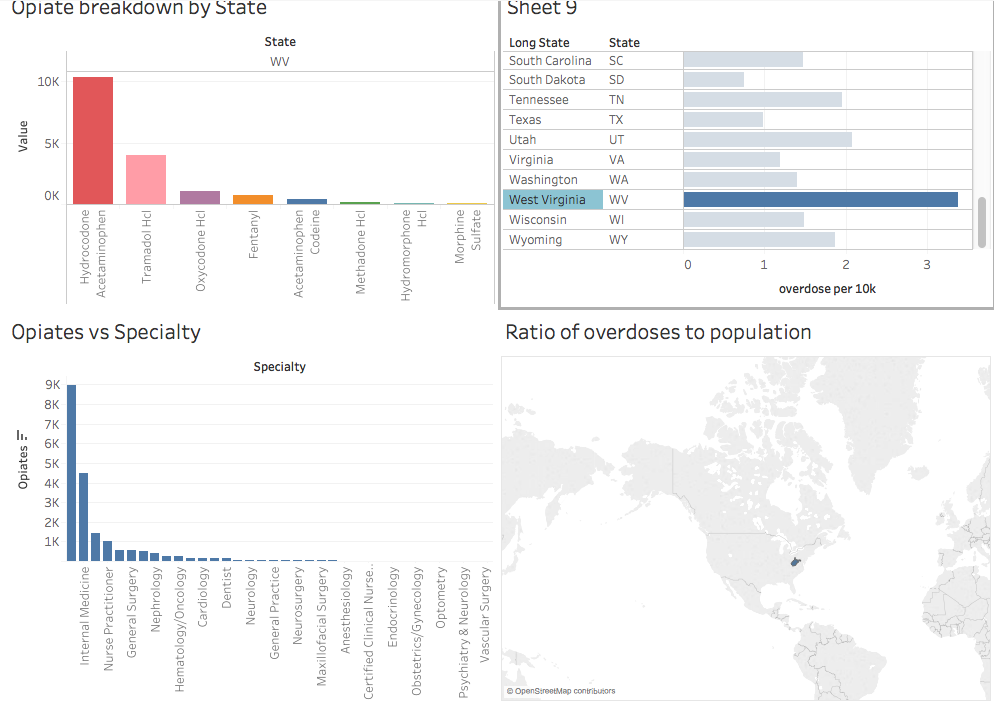

In [152]:
PATH = "/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/"
Image(filename = PATH + "opiate_state.png", width=900, height=900)

# 3. Opioid Prescriber Prediction

### Alright, I want to eventually be able to identify fraudulent prescription behaviours in prescribers, but let's start small. Can I accurately (>70%) identify Opioid Prescribers based off State, Specialty and non-opiate prescriptions?

### In theory, non-opiate prescriptions are in response to a disease or injury presented by the patient. Opiate prescriptions should (in legitimate cases) also be in response to a disease or injury being presented by the patient. For example, a patient with a broken arm may be prescribed some opiate painkillers, and also some type of anti-inflammatory medication. Therefore, non-opiate prescriptions should be able to predict opiate prescription.

## 3.1 Logistic Regression using State, Specialty and Sex of Prescriber

### Logistic Regression was chosen as the target variable is a binary class, e.g the prescriber is either an Opioid prescriber (designated value = 1), or not (designated value = 0)

In [153]:
predictors = []
for col in prescribers.columns:
    if col == 'sex':
        predictors.append(col)
    elif col[0] == '2':
        predictors.append(col)
    elif col[0] == '1':
        predictors.append(col)
    else:
        pass

X = prescribers[predictors]
y = prescribers.Opioid_Prescriber.values
print(len(predictors))
print(y)

160
[1 1 0 ..., 1 1 0]


In [154]:
X.head(2)

,sex,1_Addiction Medicine,1_Allergy/Immunology,1_Anesthesiology,1_Behavioral Analyst,1_CRNA,1_Cardiac Electrophysiology,1_Cardiac Surgery,1_Cardiology,1_Certified Clinical Nurse Specialist,...,2_SD,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
# Okay, X contains sex, specialty and state. Looks good.
# drop CRNA and and North Dakota (ND) to avoid dummy variable trap
X.drop('1_CRNA', axis=1, inplace=True)
X.drop('2_ND',axis=1,inplace=True)

/Users/lohyenwei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/lohyenwei/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [156]:
X.head(2)

,sex,1_Addiction Medicine,1_Allergy/Immunology,1_Anesthesiology,1_Behavioral Analyst,1_Cardiac Electrophysiology,1_Cardiac Surgery,1_Cardiology,1_Certified Clinical Nurse Specialist,1_Certified Nurse Midwife,...,2_SD,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
X.shape

(24618, 158)

### 3.1.1 Baseline Accuracy:

In [158]:
baseline = 1. - np.mean(y)
print('baseline:', baseline)

baseline: 0.412381184499


In [159]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [160]:
# Split data into test and train sets (train on 80% of data)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=12)

### (3.1) I'm guessing lasso penalty will be best penalty to use, as Lasso does variable selection and parameter shrinkage. With 158 variables in predictor matrix, I assume there must be some redundant variables in there.

In [161]:
# Lets set our model parameters 
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)

In [162]:
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 13.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([  1.00000e-05,   1.12332e-05, ...,   8.90215e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [163]:
# best score on the training data:
lr_gridsearch.best_score_

0.7597237737381943

In [164]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.061359072734131694, 'penalty': 'l1', 'solver': 'liblinear'}

In [165]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [166]:
# Score it on the testing data:
best_lr.score(X_test, y_test)

0.76360682372055244

### (3.1) 35% better than baseline accuracy. Not bad, considering only using state, specialty and gender. (not sure gender is too much help here)

In [167]:
# predictions and pred prob.
yhat = best_lr.predict(X_test)
yhat_pp = best_lr.predict_proba(X_test)

In [168]:
# confusion matrix
conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['opiate_prescriber', 'is_not'],
                         columns=['predicted_opiate','predicted_not'])
confusion

,predicted_opiate,predicted_not
opiate_prescriber,2367,482
is_not,682,1393


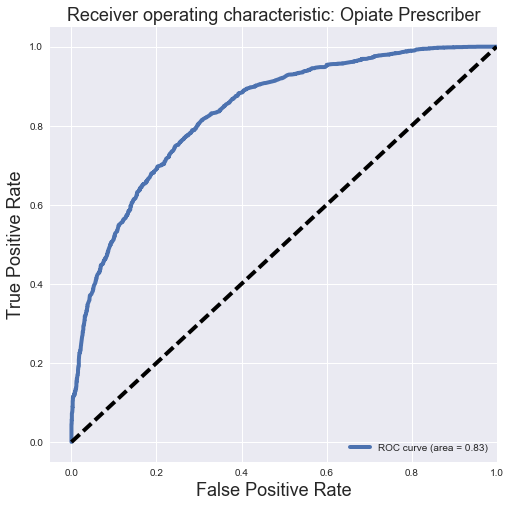

In [169]:
# Plot ROC curve

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Opiate Prescriber', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [170]:
# check cross-val score
from sklearn.model_selection import cross_val_score

In [171]:
cls_scores = cross_val_score(LogisticRegression(), Xs, y, cv=5)
print(cls_scores, np.mean(cls_scores))

[ 0.76345178  0.76482535  0.75787122  0.76944952  0.75157424] 0.761434420926


In [172]:
coef_df = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'feature':X.columns
    })

In [173]:
coef_df['abs_coef'] = np.abs(coef_df.coef)

In [174]:
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)

In [175]:
# Show non-zero coefs and predictors
coef_df[coef_df.coef != 0]

,coef,feature,abs_coef
65,-0.772868,1_Optometry,0.772868
21,0.574740,1_Emergency Medicine,0.574740
24,0.553584,1_Family Practice,0.553584
69,0.510916,1_Orthopedic Surgery,0.510916
86,-0.380312,1_Psychiatry,0.380312
64,-0.324793,1_Ophthalmology,0.324793
41,0.295524,1_Internal Medicine,0.295524
87,-0.285462,1_Psychiatry & Neurology,0.285462
7,-0.265605,1_Cardiology,0.265605
18,-0.264313,1_Dentist,0.264313


## 3.2 Logistic Regression using non-opiate prescriptions

### I dropped all the non-opiates earlier, so I'm going to call in a fresh prescribers dataset

In [176]:
prescribers = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/prescriber-info.csv')

In [177]:
# clean it quickly using same code as above

# using df.rename(columns=lambda x: x.replace('$', ''), inplace=True) from paulo.filip3 on stackoverflow
prescribers.rename(columns=lambda x: x.replace('.','_'),inplace=True)
prescribers.head(2)

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1


In [178]:
# DROP CREDENTIALS COLUMN (not using it)
prescribers.drop('Credentials',axis=1,inplace=True)
print(prescribers.columns)

Index(['NPI', 'Gender', 'State', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN_CODEINE', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX',
       'ALENDRONATE_SODIUM',
       ...
       'VERAPAMIL_ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN_SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE_HCL', 'ZOLPIDEM_TARTRATE',
       'Opioid_Prescriber'],
      dtype='object', length=255)


In [179]:
# okay, now we can drop gender, specialty, state
prescribers.drop('Gender',axis=1, inplace=True)
prescribers.drop('Specialty', axis=1, inplace=True)
prescribers.drop('State', axis=1, inplace=True)

In [180]:
prescribers.head(1)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### So it's just drugs now. I have to get rid of the opiates included in data

In [181]:
# First, get list of opiate names. (Can't use opiates because that starts with a '3_', 
# and I already have this code ready to go)
opiate_list = list(opioids['Generic_Name'].unique())
print(opiate_list)
print(len(opiate_list))

['FENTANYL_CITRATE', 'ACETAMINOPHEN_CODEINE', 'CODEINE_BUTALBITAL_ASA_CAFFEIN', 'DIHYDROCODEINE_ASPIRIN_CAFFEIN', 'MORPHINE_SULFATE', 'OPIUM_BELLADONNA_ALKALOIDS', 'BUPRENORPHINE_HCL', 'BUTALBIT_ACETAMIN_CAFF_CODEINE', 'BUTORPHANOL_TARTRATE', 'BUPRENORPHINE', 'CODEINE_CARISOPRODOL_ASPIRIN', 'CODEINE_SULFATE', 'HYDROCODONE_ACETAMINOPHEN', 'TRAMADOL_HCL', 'MEPERIDINE_HCL', 'MEPERIDINE_HCL_PF', 'HYDROMORPHONE_HCL', 'HYDROMORPHONE_HCL_PF', 'METHADONE_HCL', 'FENTANYL', 'MORPHINE_SULFATE_PF', 'OXYCODONE_HCL_ACETAMINOPHEN', 'OXYCODONE_HCL_ASPIRIN', 'HYDROCODONE_IBUPROFEN', 'LEVORPHANOL_TARTRATE', 'NALBUPHINE_HCL', 'TAPENTADOL_HCL', 'OXYMORPHONE_HCL', 'OPIUM_TINCTURE', 'OXYCODONE_HCL', 'IBUPROFEN_OXYCODONE_HCL', 'PENTAZOCINE_HCL_ACETAMINOPHEN', 'PENTAZOCINE_HCL_NALOXONE_HCL', 'PENTAZOCINE_LACTATE', 'TRAMADOL_HCL_ACETAMINOPHEN', 'DHCODEINE_BT_ACETAMINOPHN_CAFF', 'HYDROCODONE_BITARTRATE']
37


In [182]:
# Now, list of columns in prescribers
prescribers_list = list(prescribers.columns)
print(len(prescribers_list))

252


In [183]:
# Make list of things to drop (opiates in prescribers)
drop_list = []

for drug in prescribers_list:
    for opiate in opiate_list:
        if drug == opiate:
            drop_list.append(drug)

In [184]:
drop_list

['ACETAMINOPHEN_CODEINE',
 'FENTANYL',
 'HYDROCODONE_ACETAMINOPHEN',
 'HYDROMORPHONE_HCL',
 'METHADONE_HCL',
 'MORPHINE_SULFATE',
 'OXYCODONE_HCL',
 'TRAMADOL_HCL']

In [185]:
prescribers.shape

(25000, 252)

In [186]:
# Now we drop these 8 opiates from prescribers!
for opiate in drop_list:
    prescribers.drop(opiate, axis=1, inplace=True)

In [187]:
prescribers.shape

(25000, 244)

In [188]:
prescribers.head(2)

,NPI,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,35,1


In [189]:
# set up predictor matrix
predictors = []
prescribers_list = list(prescribers.columns)
for item in prescribers_list:
    if item == 'NPI':
        pass
    elif item == 'Opioid_Prescriber':
        pass
    elif item == 'OXYCODONE_ACETAMINOPHEN':
        pass
    elif item == 'MORPHINE_SULFATE_ER':
        pass
    elif item == 'OXYCONTIN':
        pass
    elif item == 'DIPHENOXYLATE_ATROPINE':
        pass
    else:
        predictors.append(item)
print(len(predictors))

238


### NOTE: In above code, I have removed Oxycodone_Acetaminophen, Morphine_Sulfate_ER, and Oxycontin as these are opioids that got past my cleaning. In previous iterations of this logreg, I pulled out the absolute correlation coefficients, and these three drugs caught my attention. Further research showed them to be opioids, so I removed them from predictors and ran logistic regression again. Have also gone back and added the three extra opiates into the previous sections where appropriate

In [190]:
X_non = prescribers[predictors]
y_non = prescribers.Opioid_Prescriber.values

### (3.2) Baseline Accuracy

In [191]:
baseline = 1. - np.mean(y_non)
print('baseline:', baseline)

baseline: 0.41248


In [192]:
Xs_non = ss.fit_transform(X_non)

In [193]:
# Split data into test and train sets (train on 80% of data)
X_non_train, X_non_test, y_non_train, y_non_test = train_test_split(Xs_non, y_non, test_size=0.2, random_state=12)

In [194]:
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)

In [195]:
lr_gridsearch.fit(X_non_train, y_non_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 13.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([  1.00000e-05,   1.12332e-05, ...,   8.90215e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [196]:
# best score on the training data:
lr_gridsearch.best_score_

0.7655

In [197]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.061359072734131694, 'penalty': 'l1', 'solver': 'liblinear'}

In [198]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [199]:
# Score it on the testing data:
best_lr.score(X_non_test, y_non_test)

0.76780000000000004

### (3.2) Okay, I managed to improve from the previous logistic regression by about half a percent. Interesting. I would have expected the non-opiate prescriptions to perform significantly better than just using State, Specialty and Sex

In [200]:
# predictions and pred prob.
yhat_non = best_lr.predict(X_non_test)
yhat_pp_non = best_lr.predict_proba(X_non_test)

In [201]:
# confusion matrix
conmat = np.array(confusion_matrix(y_non_test, yhat_non, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['opiate_prescriber', 'is_not'],
                         columns=['predicted_opiate','predicted_not'])
confusion

,predicted_opiate,predicted_not
opiate_prescriber,2081,862
is_not,299,1758


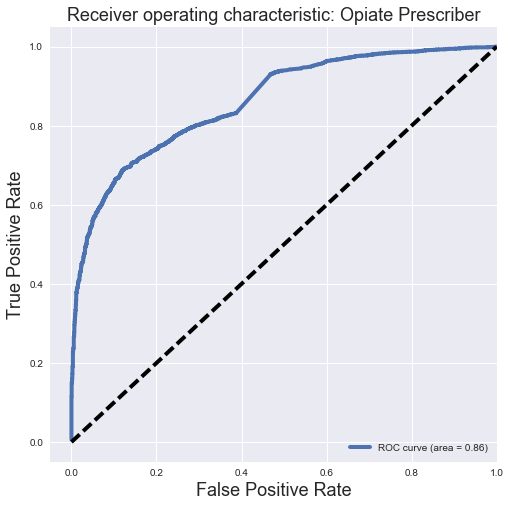

In [202]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_non_test, yhat_pp_non[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: Opiate Prescriber', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [203]:
# Check cross-validation scores
cls_scores = cross_val_score(LogisticRegression(), Xs_non, y_non, cv=5)
print(cls_scores, np.mean(cls_scores))

[ 0.76964607  0.75624875  0.7616      0.77895579  0.75655131] 0.764600384491


In [204]:
# What are the important variables?
coef_df_non = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'feature':X_non.columns
    })

In [205]:
coef_df_non['abs_coef'] = np.abs(coef_df.coef)

In [206]:
# sort by absolute value of coefficient (magnitude)
coef_df_non.sort_values('abs_coef', ascending=False, inplace=True)

In [207]:
# Show non-zero coefs and predictors
coef_df_non[coef_df_non.coef != 0]

,coef,feature,abs_coef
21,0.021880,BENICAR,0.574740
24,0.034893,BISOPROLOL_HYDROCHLOROTHIAZIDE,0.553584
69,-0.058964,DOXAZOSIN_MESYLATE,0.510916
86,0.713134,GABAPENTIN,0.380312
64,-0.037991,DIOVAN,0.324793
41,0.039933,CILOSTAZOL,0.295524
7,0.016117,AMIODARONE_HCL,0.265605
28,-0.163356,BUPROPION_XL,0.238025
2,-0.026740,ADVAIR_DISKUS,0.217021
19,-0.236806,BD_ULTRA_FINE_PEN_NEEDLE,0.212793


## 3.3 Decision Tree Classifier on All Features

### (3.3) Let's see if a decision tree classifier can improve on the results I got from logistic regression.

In [208]:
# First, build a prescribers dataframe with all features intact
prescribers = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/prescriber-info.csv')

In [209]:
# DROP CREDENTIALS COLUMN (not using it)
prescribers.drop('Credentials',axis=1,inplace=True)
print(prescribers.columns)
print(prescribers.shape)

Index(['NPI', 'Gender', 'State', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       'ALENDRONATE.SODIUM',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=255)
(25000, 255)


In [210]:
# Clean up prescribers
# First, replace '.' with '_' across the entire dataframe
# using df.rename(columns=lambda x: x.replace('$', ''), inplace=True) from paulo.filip3 on stackoverflow
prescribers.rename(columns=lambda x: x.replace('.','_'),inplace=True)
prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [211]:
opiates = ['ACETAMINOPHEN_CODEINE','FENTANYL','HYDROCODONE_ACETAMINOPHEN','HYDROMORPHONE_HCL','METHADONE_HCL',
          'MORPHINE_SULFATE','OXYCODONE_HCL','TRAMADOL_HCL','OXYCODONE_ACETAMINOPHEN','MORPHINE_SULFATE_ER',
          'OXYCONTIN', 'DIPHENOXYLATE_ATROPINE']

In [212]:
# now drop prescribers column if they're found in opiates
for opiate in opiates:
    for item in prescribers.columns:
        if item == opiate:
            prescribers.drop(item, axis=1, inplace=True)
prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [213]:
# using the list of states taken from overdoses previously, let's drop the extra states
drop_state = []
def drop_extra(x_list):
    for state in x_list:
        if state not in state_list:
            drop_state.append(state)
    return drop_state

In [214]:
prescribers_state_list = prescribers['State'].tolist()
print(len(prescribers_state_list))

25000


In [215]:
drop_extra(prescribers_state_list)
print(len(drop_state))

320


In [216]:
from collections import Counter
c = Counter(drop_state)
print(c.items())

dict_items([('PR', 231), ('DC', 79), ('AE', 2), ('ZZ', 2), ('GU', 2), ('AA', 1), ('VI', 3)])


In [217]:
# okay, so we drop these items
# from ksookall on stack, df = df[~df['your column'].isin(['list of strings'])]
prescribers = prescribers[~prescribers['State'].isin(['PR','DC','AE','ZZ','GU','AA','VT'])]
print(prescribers.State.nunique())

50


In [218]:
prescribers_state = prescribers['State'].tolist()
print(len(prescribers_state))

24618


### (3.3) Dummy Variable Creation (for decision tree)

In [219]:
# turn gender, state, specialty into dummy variables
# write a function to create dictionary for State = '2_' indicates a State (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
state_dict={}
def state_dummy(state):
    for st in state:
        state_dict[st]='2_' + st

In [220]:
state_dummy(prescribers_state)

In [221]:
# Create field with mapped location dictionary
prescribers['state_val'] = prescribers['State'].map(state_dict)
prescribers[['State', 'state_val']].head(2)

,State,state_val
0,TX,2_TX
1,AL,2_AL


In [222]:
# Create dummies for locations

state_val_dummies = pd.get_dummies(prescribers['state_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, state_val_dummies], axis=1)

prescribers.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,2_SD,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
# convert gender to dummies
gender_dummies = pd.get_dummies(prescribers['Gender'])

# join dummies to main dataframe
prescribers = pd.concat([prescribers, gender_dummies], axis=1)
prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY,F,M
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [224]:
# now we do the same for specialty
spec_list = prescribers['Specialty'].tolist()
print(len(spec_list))

24618


In [225]:
# write a function to create dictionary for specialty = '1_' indicates a specialty (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
spec_dict={}
def spec_dummy(specialty):
    for spec in specialty:
        spec_dict[spec]='1_' + spec

In [226]:
spec_dummy(spec_list)
print(len(spec_dict))

108


In [227]:
# Create field with mapped location dictionary
prescribers['spec_val'] = prescribers['Specialty'].map(spec_dict)
prescribers[['Specialty', 'spec_val']].head(2)

,Specialty,spec_val
0,Dentist,1_Dentist
1,General Surgery,1_General Surgery


In [228]:
# Create dummies for locations

spec_val_dummies = pd.get_dummies(prescribers['spec_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, spec_val_dummies], axis=1)

prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
# don't need NPI, drop that, and also drop the redundant variables
prescribers.drop('NPI', axis=1, inplace=True)
prescribers.drop('Gender', axis=1, inplace=True)
prescribers.drop('State', axis=1, inplace=True)
prescribers.drop('Specialty', axis=1, inplace=True)
prescribers.drop('state_val', axis=1, inplace=True)
prescribers.drop('spec_val', axis=1, inplace=True)
prescribers.drop('F', axis=1, inplace=True)
prescribers.drop('1_CRNA', axis=1, inplace=True)
prescribers.drop('2_ND',axis=1,inplace=True)
prescribers.head(1)

,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,AMLODIPINE_BESYLATE,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
# Make list of predictors
predictors = list(prescribers.columns)
predictors.remove('Opioid_Prescriber')
X_dec = prescribers[predictors]
y_dec = prescribers.Opioid_Prescriber

In [231]:
X_dec.head(2)

,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,AMLODIPINE_BESYLATE,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,0


In [232]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score

In [233]:
dtc1 = DecisionTreeClassifier(max_depth=1)
dtc2 = DecisionTreeClassifier(max_depth=2)
dtc3 = DecisionTreeClassifier(max_depth=3)
dtc5 = DecisionTreeClassifier(max_depth=5)
dtc7 = DecisionTreeClassifier(max_depth=7)
dtcN = DecisionTreeClassifier(max_depth=None)

In [234]:
dtc1.fit(X_dec, y_dec)
dtc2.fit(X_dec, y_dec)
dtc3.fit(X_dec, y_dec)
dtc5.fit(X_dec, y_dec)
dtc7.fit(X_dec, y_dec)
dtcN.fit(X_dec, y_dec)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [235]:
dtc1_scores = cross_val_score(dtc1, X_dec, y_dec, cv=4)
dtc2_scores = cross_val_score(dtc2, X_dec, y_dec, cv=4)
dtc3_scores = cross_val_score(dtc3, X_dec, y_dec, cv=4)
dtc5_scores = cross_val_score(dtc5, X_dec, y_dec, cv=4)
dtc7_scores = cross_val_score(dtc7, X_dec, y_dec, cv=4)
dtcN_scores = cross_val_score(dtcN, X_dec, y_dec, cv=4)

print(dtc1_scores, np.mean(dtc1_scores))
print(dtc2_scores, np.mean(dtc2_scores))
print(dtc3_scores, np.mean(dtc3_scores))
print(dtc5_scores, np.mean(dtc5_scores))
print(dtc7_scores, np.mean(dtc7_scores))
print(dtcN_scores, np.mean(dtcN_scores))

[ 0.61640942  0.5962632   0.62772181  0.61260968] 0.613251028899
[ 0.65913891  0.63298132  0.66558336  0.66119597] 0.654724889494
[ 0.68432169  0.67164907  0.70279493  0.69125772] 0.687505851042
[ 0.73696182  0.69845654  0.73919402  0.73383165] 0.727111008354
[ 0.74849716  0.72883834  0.7518687   0.74309392] 0.743074531382
[ 0.7850528   0.78976442  0.78258044  0.7679558 ] 0.781338364591


### 78% accuracy! Slightly better than logistic regression on State/Spec and non-opiate prescriptions separately. What are the most important features?

In [236]:
fi = pd.DataFrame({
        'feature':X_dec.columns,
        'importance':dtcN.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)

In [237]:
fi.head(2)

,feature,importance
86,GABAPENTIN,0.137736
308,1_Emergency Medicine,0.043797


## 3.4 Compare important features from the models run

### Let's have a look at the most important features from each model and see if they make sense

### (3.4) Top ten features from State/spec logistic regression

In [238]:
coef_df.head(10)

,coef,feature,abs_coef
65,-0.772868,1_Optometry,0.772868
21,0.574740,1_Emergency Medicine,0.574740
24,0.553584,1_Family Practice,0.553584
69,0.510916,1_Orthopedic Surgery,0.510916
86,-0.380312,1_Psychiatry,0.380312
64,-0.324793,1_Ophthalmology,0.324793
41,0.295524,1_Internal Medicine,0.295524
87,-0.285462,1_Psychiatry & Neurology,0.285462
7,-0.265605,1_Cardiology,0.265605
18,-0.264313,1_Dentist,0.264313


### Optometrists are the least likely specialty to prescribe opiates, while prescribers working in Emergency Medicine are the most likely. Since opiates are painkillers, this seems to make sense.

### (3.4) Top ten features from non-opiate logistic regression

In [239]:
coef_df_non.head(10)

,coef,feature,abs_coef
65,0.000000,DIVALPROEX_SODIUM,0.772868
21,0.021880,BENICAR,0.574740
24,0.034893,BISOPROLOL_HYDROCHLOROTHIAZIDE,0.553584
69,-0.058964,DOXAZOSIN_MESYLATE,0.510916
86,0.713134,GABAPENTIN,0.380312
64,-0.037991,DIOVAN,0.324793
41,0.039933,CILOSTAZOL,0.295524
87,0.000000,GEMFIBROZIL,0.285462
7,0.016117,AMIODARONE_HCL,0.265605
18,0.000000,BACLOFEN,0.264313


### It appears that there are several non-opiate prescription medication that do carry significant correlation with opiate prescription

### (3.4) Top ten features from decision tree classifier on all features

In [240]:
fi.head(10)

,feature,importance
86,GABAPENTIN,0.137736
308,1_Emergency Medicine,0.043797
166,OMEPRAZOLE,0.035233
11,AMOXICILLIN,0.029554
42,CIPROFLOXACIN_HCL,0.029388
356,1_Orthopedic Surgery,0.025651
118,LATANOPROST,0.022223
315,1_General Surgery,0.020400
0,ABILIFY,0.018882
100,IBUPROFEN,0.016220


# 4. Opiate Prescription Prediction

### In Section 3, I have established that State, Specialty and Non-opiate Prescriptions carry correlations with opiate prescription. In this section, I will outline my approach to developing a model that predicts the total volume of opiate prescription.

## 4.1 Linear Regression

In [241]:
# Let's reset the prescribers dataset
prescribers = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/prescriber-info.csv')

In [242]:
# DROP CREDENTIALS COLUMN (not using it)
prescribers.drop('Credentials',axis=1,inplace=True)
print(prescribers.columns)
print(prescribers.shape)

Index(['NPI', 'Gender', 'State', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       'ALENDRONATE.SODIUM',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=255)
(25000, 255)


In [243]:
prescribers.rename(columns=lambda x: x.replace('.','_'),inplace=True)
prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,VERAPAMIL_ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN_SODIUM,XARELTO,ZETIA,ZIPRASIDONE_HCL,ZOLPIDEM_TARTRATE,Opioid_Prescriber
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [244]:
prescribers_state_list = prescribers['State'].tolist()

In [245]:
drop_state=[]
drop_extra(prescribers_state_list)
print(len(drop_state))

320


In [246]:
from collections import Counter
c = Counter(drop_state)
print(c.items())

dict_items([('PR', 231), ('DC', 79), ('AE', 2), ('ZZ', 2), ('GU', 2), ('AA', 1), ('VI', 3)])


In [247]:
# okay, so we drop these items
# from ksookall on stack, df = df[~df['your column'].isin(['list of strings'])]
prescribers = prescribers[~prescribers['State'].isin(['PR','DC','AE','ZZ','GU','AA','VT'])]
print(prescribers.State.nunique())

50


In [248]:
prescribers_state = prescribers['State'].tolist()
print(len(prescribers_state))

24618


In [249]:
# turn gender, state, specialty into dummy variables
# write a function to create dictionary for State = '2_' indicates a State (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
state_dict={}
def state_dummy(state):
    for st in state:
        state_dict[st]='2_' + st

In [250]:
state_dummy(prescribers_state)
print(state_dict)

{'TX': '2_TX', 'AL': '2_AL', 'NY': '2_NY', 'AZ': '2_AZ', 'NV': '2_NV', 'PA': '2_PA', 'NH': '2_NH', 'WI': '2_WI', 'CO': '2_CO', 'OH': '2_OH', 'MA': '2_MA', 'CT': '2_CT', 'FL': '2_FL', 'MN': '2_MN', 'UT': '2_UT', 'IA': '2_IA', 'IL': '2_IL', 'MT': '2_MT', 'IN': '2_IN', 'VA': '2_VA', 'CA': '2_CA', 'OR': '2_OR', 'NE': '2_NE', 'MI': '2_MI', 'NM': '2_NM', 'TN': '2_TN', 'KS': '2_KS', 'LA': '2_LA', 'MD': '2_MD', 'MO': '2_MO', 'AR': '2_AR', 'NC': '2_NC', 'NJ': '2_NJ', 'SC': '2_SC', 'WY': '2_WY', 'ME': '2_ME', 'OK': '2_OK', 'ND': '2_ND', 'KY': '2_KY', 'GA': '2_GA', 'DE': '2_DE', 'WA': '2_WA', 'RI': '2_RI', 'WV': '2_WV', 'AK': '2_AK', 'ID': '2_ID', 'HI': '2_HI', 'MS': '2_MS', 'SD': '2_SD', 'VI': '2_VI'}


In [251]:
# Create field with mapped location dictionary
prescribers['state_val'] = prescribers['State'].map(state_dict)
prescribers[['State', 'state_val']].head()

,State,state_val
0,TX,2_TX
1,AL,2_AL
2,NY,2_NY
3,AZ,2_AZ
4,NV,2_NV


In [252]:
# Create dummies for locations

state_val_dummies = pd.get_dummies(prescribers['state_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, state_val_dummies], axis=1)

prescribers.head()

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,2_SD,2_TN,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1427182161,F,NY,General Practice,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1669567541,M,AZ,Internal Medicine,0,43,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
4,1679650949,M,NV,Hematology/Oncology,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [253]:
# convert gender to dummies
gender_dummies = pd.get_dummies(prescribers['Gender'])

# join dummies to main dataframe
prescribers = pd.concat([prescribers, gender_dummies], axis=1)
prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,2_TX,2_UT,2_VA,2_VI,2_WA,2_WI,2_WV,2_WY,F,M
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [254]:
# now we do the same for specialty
spec_list = prescribers['Specialty'].tolist()
print(len(spec_list))

24618


In [255]:
# write a function to create dictionary for specialty = '1_' indicates a specialty (inspired by 
# Tom Croshaw's work in Project 4)
# this will be a useful identifier when creating dummy columns
spec_dict={}
def spec_dummy(specialty):
    for spec in specialty:
        spec_dict[spec]='1_' + spec

In [256]:
spec_dummy(spec_list)
print(len(spec_dict))

108


In [257]:
# Create field with mapped location dictionary
prescribers['spec_val'] = prescribers['Specialty'].map(spec_dict)
prescribers[['Specialty', 'spec_val']].head()

,Specialty,spec_val
0,Dentist,1_Dentist
1,General Surgery,1_General Surgery
2,General Practice,1_General Practice
3,Internal Medicine,1_Internal Medicine
4,Hematology/Oncology,1_Hematology/Oncology


In [258]:
# Create dummies for locations

spec_val_dummies = pd.get_dummies(prescribers['spec_val'])

# Join the dummy variables to the main dataframe

prescribers = pd.concat([prescribers, spec_val_dummies], axis=1)

prescribers.head(1)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
# also no longer need gender, state, specialty, state_val, spec_val (these have been converted to dummies)
prescribers.drop('Gender', axis=1, inplace=True)
prescribers.drop('State', axis=1, inplace=True)
prescribers.drop('Specialty', axis=1, inplace=True)
prescribers.drop('state_val', axis=1, inplace=True)
prescribers.drop('spec_val', axis=1, inplace=True)
prescribers.shape

(24618, 412)

In [260]:
opiates

['ACETAMINOPHEN_CODEINE',
 'FENTANYL',
 'HYDROCODONE_ACETAMINOPHEN',
 'HYDROMORPHONE_HCL',
 'METHADONE_HCL',
 'MORPHINE_SULFATE',
 'OXYCODONE_HCL',
 'TRAMADOL_HCL',
 'OXYCODONE_ACETAMINOPHEN',
 'MORPHINE_SULFATE_ER',
 'OXYCONTIN',
 'DIPHENOXYLATE_ATROPINE']

In [261]:
prescribers['opiates'] = prescribers[opiates].sum(axis=1)

In [262]:
prescribers.head(1)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17


### (4.1) Now, I want to predict opiates based off the non-opiate variables. Let's look at their correlations and plot some of them to see if it's linear

In [263]:
show_corr=prescribers.drop(labels='opiates',axis=1).corrwith(prescribers['opiates'])
print(show_corr.sort_values(ascending=False))

HYDROCODONE_ACETAMINOPHEN                                           0.886149
OXYCODONE_ACETAMINOPHEN                                             0.828022
MORPHINE_SULFATE_ER                                                 0.786996
FENTANYL                                                            0.775719
CYCLOBENZAPRINE_HCL                                                 0.757871
OXYCODONE_HCL                                                       0.721790
GABAPENTIN                                                          0.695158
MORPHINE_SULFATE                                                    0.683861
TIZANIDINE_HCL                                                      0.683336
LYRICA                                                              0.668187
OXYCONTIN                                                           0.665834
TRAMADOL_HCL                                                        0.616307
CARISOPRODOL                                                        0.585633

### (4.1) Some of the variables are opiates, which obviously have a high correlation with total opiate prescriptions. Let's plot some of the others and have a look-see

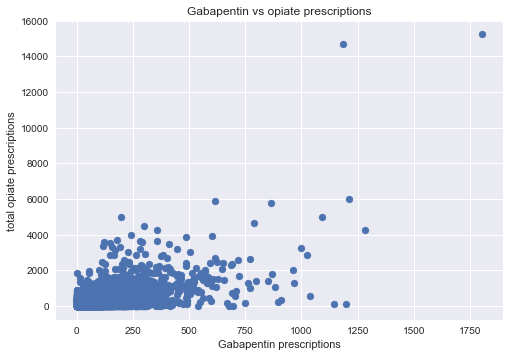

In [264]:
plt.scatter(prescribers.GABAPENTIN, prescribers.opiates)
plt.xlabel("Gabapentin prescriptions")
plt.ylabel("total opiate prescriptions")
plt.title("Gabapentin vs opiate prescriptions")
plt.show()

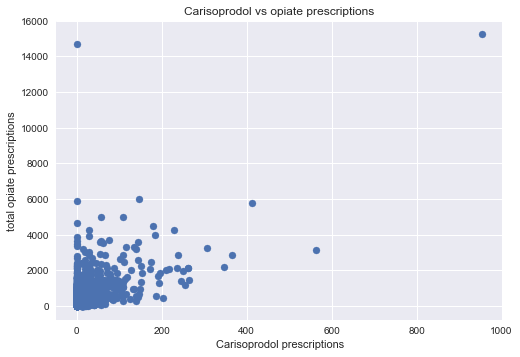

In [265]:
plt.scatter(prescribers.CARISOPRODOL, prescribers.opiates)
plt.xlabel("Carisoprodol prescriptions")
plt.ylabel("total opiate prescriptions")
plt.title("Carisoprodol vs opiate prescriptions")
plt.show()

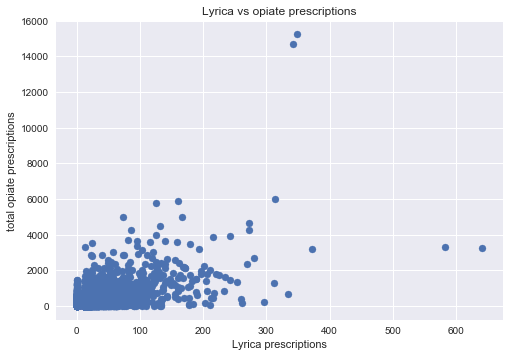

In [266]:
plt.scatter(prescribers.LYRICA, prescribers.opiates)
plt.xlabel("Lyrica prescriptions")
plt.ylabel("total opiate prescriptions")
plt.title("Lyrica vs opiate prescriptions")
plt.show()

### There does seem to be some linearity in the data against opiate prescriptions, especially at the lower levels. Let's do a linear regression to try and predict total opiate prescription

In [267]:
pred_vals = list(prescribers.columns)
print(pred_vals)

['NPI', 'ABILIFY', 'ACETAMINOPHEN_CODEINE', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX', 'ALENDRONATE_SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM', 'AMIODARONE_HCL', 'AMITRIPTYLINE_HCL', 'AMLODIPINE_BESYLATE', 'AMLODIPINE_BESYLATE_BENAZEPRIL', 'AMOXICILLIN', 'AMOX_TR_POTASSIUM_CLAVULANATE', 'AMPHETAMINE_SALT_COMBO', 'ATENOLOL', 'ATORVASTATIN_CALCIUM', 'AVODART', 'AZITHROMYCIN', 'BACLOFEN', 'BD_ULTRA_FINE_PEN_NEEDLE', 'BENAZEPRIL_HCL', 'BENICAR', 'BENICAR_HCT', 'BENZTROPINE_MESYLATE', 'BISOPROLOL_HYDROCHLOROTHIAZIDE', 'BRIMONIDINE_TARTRATE', 'BUMETANIDE', 'BUPROPION_HCL_SR', 'BUPROPION_XL', 'BUSPIRONE_HCL', 'BYSTOLIC', 'CARBAMAZEPINE', 'CARBIDOPA_LEVODOPA', 'CARISOPRODOL', 'CARTIA_XT', 'CARVEDILOL', 'CEFUROXIME', 'CELEBREX', 'CEPHALEXIN', 'CHLORHEXIDINE_GLUCONATE', 'CHLORTHALIDONE', 'CILOSTAZOL', 'CIPROFLOXACIN_HCL', 'CITALOPRAM_HBR', 'CLINDAMYCIN_HCL', 'CLOBETASOL_PROPIONATE', 'CLONAZEPAM', 'CLONIDINE_HCL', 'CLOPIDOGREL', 'CLOTRIMAZOLE_BETAMETHASONE', 'COLCRYS', 'COMBIVENT_RESPIMAT', 'CRESTOR', '

In [268]:
pred_vals.remove('ACETAMINOPHEN_CODEINE')
pred_vals.remove('TRAMADOL_HCL')
pred_vals.remove('HYDROMORPHONE_HCL')
pred_vals.remove('OXYCODONE_ACETAMINOPHEN')
pred_vals.remove('FENTANYL')
pred_vals.remove('HYDROCODONE_ACETAMINOPHEN')
pred_vals.remove('MORPHINE_SULFATE')
pred_vals.remove('MORPHINE_SULFATE_ER')
pred_vals.remove('Opioid_Prescriber')
pred_vals.remove('OXYCODONE_HCL')
pred_vals.remove('METHADONE_HCL')
pred_vals.remove('OXYCONTIN')
pred_vals.remove('DIPHENOXYLATE_ATROPINE')

In [269]:
pred_vals.pop(-1)

'opiates'

In [339]:
len(pred_vals)

399

### (4.1) Checking to make sure all opiates and sum of opiate columns have been removed

In [270]:
print(pred_vals)

['NPI', 'ABILIFY', 'ACYCLOVIR', 'ADVAIR_DISKUS', 'AGGRENOX', 'ALENDRONATE_SODIUM', 'ALLOPURINOL', 'ALPRAZOLAM', 'AMIODARONE_HCL', 'AMITRIPTYLINE_HCL', 'AMLODIPINE_BESYLATE', 'AMLODIPINE_BESYLATE_BENAZEPRIL', 'AMOXICILLIN', 'AMOX_TR_POTASSIUM_CLAVULANATE', 'AMPHETAMINE_SALT_COMBO', 'ATENOLOL', 'ATORVASTATIN_CALCIUM', 'AVODART', 'AZITHROMYCIN', 'BACLOFEN', 'BD_ULTRA_FINE_PEN_NEEDLE', 'BENAZEPRIL_HCL', 'BENICAR', 'BENICAR_HCT', 'BENZTROPINE_MESYLATE', 'BISOPROLOL_HYDROCHLOROTHIAZIDE', 'BRIMONIDINE_TARTRATE', 'BUMETANIDE', 'BUPROPION_HCL_SR', 'BUPROPION_XL', 'BUSPIRONE_HCL', 'BYSTOLIC', 'CARBAMAZEPINE', 'CARBIDOPA_LEVODOPA', 'CARISOPRODOL', 'CARTIA_XT', 'CARVEDILOL', 'CEFUROXIME', 'CELEBREX', 'CEPHALEXIN', 'CHLORHEXIDINE_GLUCONATE', 'CHLORTHALIDONE', 'CILOSTAZOL', 'CIPROFLOXACIN_HCL', 'CITALOPRAM_HBR', 'CLINDAMYCIN_HCL', 'CLOBETASOL_PROPIONATE', 'CLONAZEPAM', 'CLONIDINE_HCL', 'CLOPIDOGREL', 'CLOTRIMAZOLE_BETAMETHASONE', 'COLCRYS', 'COMBIVENT_RESPIMAT', 'CRESTOR', 'CYCLOBENZAPRINE_HCL', 'DE

### (4.1) Looks good, on to linear regression!

In [271]:
# set up X and y for plot
X_lin = prescribers[pred_vals]
# need to create a column of total opiates for y
y_lin = prescribers.opiates

In [272]:
X_lin.head(2)

,NPI,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245278100,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV
Xs_lin = ss.fit_transform(X_lin)

In [274]:
# split into train_test
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(Xs_lin, y_lin, train_size=0.8, random_state=8)

lr = LinearRegression(fit_intercept=True)

lr.fit(X_lin_train, y_lin_train)

lr.score(X_lin_test, y_lin_test)

-2.3685619989261076e+25

### (4.1) Uh. Wow. Okay. This could be caused by the standardization of variables. The non-opiate prescriptions are a numerical value (e.g 2 prescriptions worth double the value of 1 prescription), while the state and specialty variables are binary 1/0 classes. Let's try it without standardizing.

In [275]:
# split into train_test
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, train_size=0.8, random_state=8)

lr = LinearRegression(fit_intercept=True)

lr.fit(X_lin_train, y_lin_train)

lr.score(X_lin_test, y_lin_test)

0.78987701740576732

### (4.1) Awesome! This indicates that non-opiate prescriptions have a strong linear relationship with opiate prescription. Let's try using lasso to reduce multicollinearity and try and improve the model.

In [276]:
# use lasso to find valuable variables and reduce multicollinearity
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_lin, y_lin)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

3461166.313


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished


In [277]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_lin, y_lin, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[  1.71776533e-04  -6.89859403e-04   1.48664317e-04   2.82976887e-04
  -5.32513073e-04  -5.26236469e-04  -5.98274245e-04   4.57011391e-04
  -3.64245735e-03  -8.12398002e-05]
-0.000501015121377


### (4.1) Ouch. The poor cross-validation score suggests that the linear regression model heavily relies on all variables, and that there isn't much multicollinearity in the variables.

## 4.2 Decision Tree Regressor

### Let's try and beat the performance of the linear regression model with a decision tree regressor (I don't have high hopes for this one, as the decision tree model seems like it would do poorly with this type of prediction). The model could very easily go down a path that doesn't provide good predictions.

In [278]:
reg_scores = cross_val_score(LinearRegression(), X_lin, y_lin, cv=10)

print(reg_scores, np.mean(reg_scores))

linreg = LinearRegression().fit(X_lin, y_lin)

[ 0.82036822  0.80988068  0.7248127   0.81157742  0.76375631  0.82263517
  0.74453151  0.83904906  0.67111673  0.60783923] 0.761556701802


In [279]:
dtr1 = DecisionTreeRegressor(max_depth=1)
dtr2 = DecisionTreeRegressor(max_depth=2)
dtr3 = DecisionTreeRegressor(max_depth=3)
dtrN = DecisionTreeRegressor(max_depth=None)

In [280]:
dtr1.fit(X_lin, y_lin)
dtr2.fit(X_lin, y_lin)
dtr3.fit(X_lin, y_lin)
dtrN.fit(X_lin, y_lin)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [281]:
dtr1_scores = cross_val_score(dtr1, X_lin, y_lin, cv=4)
dtr2_scores = cross_val_score(dtr2, X_lin, y_lin, cv=4)
dtr3_scores = cross_val_score(dtr3, X_lin, y_lin, cv=4)
dtrN_scores = cross_val_score(dtrN, X_lin, y_lin, cv=4)

print(dtr1_scores, np.mean(dtr1_scores))
print(dtr2_scores, np.mean(dtr2_scores))
print(dtr3_scores, np.mean(dtr3_scores))
print(dtrN_scores, np.mean(dtrN_scores))

[-0.00092643  0.23634476  0.23513686  0.22589136] 0.1741116386
[ 0.34350848  0.25992191  0.26013165  0.40134267] 0.316226177676
[ 0.49374782  0.67052964  0.18987243  0.51435255] 0.467125610041
[ 0.62595094  0.6565039   0.38964788  0.53067869] 0.550695349976


### (4.2) Welp. Linear regression is still king. How would PCA do? PCA works by reducing dimensions and taking their eigenvalues/eigenvectors. If the independent model variables don't have a lot of collinearity, PCA might do poorly

## 4.3 PCA on numerical data

### I have chosen to only do PCA on numerical data as there is some debate online on the use of PCA on categorical or mixed data. I still have 250 non-opiate prescription medication, so dimension reduction on the numerical data would still be useful

In [282]:
prescribers.head()

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17
1,1245278100,0,0,0,0,0,0,0,134,0,...,0,0,0,0,0,0,0,0,0,362
2,1427182161,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1669567541,0,43,0,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,559
4,1679650949,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66


In [283]:
# make list of categorical columns)
cat_vals = []
for c in prescribers.columns:
    if c[0].isdigit()== True:
        cat_vals.append(c)
len(cat_vals)

158

In [284]:
cat_vals

['2_AK',
 '2_AL',
 '2_AR',
 '2_AZ',
 '2_CA',
 '2_CO',
 '2_CT',
 '2_DE',
 '2_FL',
 '2_GA',
 '2_HI',
 '2_IA',
 '2_ID',
 '2_IL',
 '2_IN',
 '2_KS',
 '2_KY',
 '2_LA',
 '2_MA',
 '2_MD',
 '2_ME',
 '2_MI',
 '2_MN',
 '2_MO',
 '2_MS',
 '2_MT',
 '2_NC',
 '2_ND',
 '2_NE',
 '2_NH',
 '2_NJ',
 '2_NM',
 '2_NV',
 '2_NY',
 '2_OH',
 '2_OK',
 '2_OR',
 '2_PA',
 '2_RI',
 '2_SC',
 '2_SD',
 '2_TN',
 '2_TX',
 '2_UT',
 '2_VA',
 '2_VI',
 '2_WA',
 '2_WI',
 '2_WV',
 '2_WY',
 '1_Addiction Medicine',
 '1_Allergy/Immunology',
 '1_Anesthesiology',
 '1_Behavioral Analyst',
 '1_CRNA',
 '1_Cardiac Electrophysiology',
 '1_Cardiac Surgery',
 '1_Cardiology',
 '1_Certified Clinical Nurse Specialist',
 '1_Certified Nurse Midwife',
 '1_Chiropractic',
 '1_Clinic/Center',
 '1_Clinical Pharmacology',
 '1_Colon & Rectal Surgery',
 '1_Colorectal Surgery (formerly proctology)',
 '1_Community Health Worker',
 '1_Counselor',
 '1_Critical Care (Intensivists)',
 '1_Dentist',
 '1_Dermatology',
 '1_Diagnostic Radiology',
 '1_Emergency Med

In [285]:
# drop cat_vals from prescribers
removed_statespec = []
for item in list(prescribers.columns):
    if item[0].isdigit() == False:
        removed_statespec.append(item)
removed_statespec

['NPI',
 'ABILIFY',
 'ACETAMINOPHEN_CODEINE',
 'ACYCLOVIR',
 'ADVAIR_DISKUS',
 'AGGRENOX',
 'ALENDRONATE_SODIUM',
 'ALLOPURINOL',
 'ALPRAZOLAM',
 'AMIODARONE_HCL',
 'AMITRIPTYLINE_HCL',
 'AMLODIPINE_BESYLATE',
 'AMLODIPINE_BESYLATE_BENAZEPRIL',
 'AMOXICILLIN',
 'AMOX_TR_POTASSIUM_CLAVULANATE',
 'AMPHETAMINE_SALT_COMBO',
 'ATENOLOL',
 'ATORVASTATIN_CALCIUM',
 'AVODART',
 'AZITHROMYCIN',
 'BACLOFEN',
 'BD_ULTRA_FINE_PEN_NEEDLE',
 'BENAZEPRIL_HCL',
 'BENICAR',
 'BENICAR_HCT',
 'BENZTROPINE_MESYLATE',
 'BISOPROLOL_HYDROCHLOROTHIAZIDE',
 'BRIMONIDINE_TARTRATE',
 'BUMETANIDE',
 'BUPROPION_HCL_SR',
 'BUPROPION_XL',
 'BUSPIRONE_HCL',
 'BYSTOLIC',
 'CARBAMAZEPINE',
 'CARBIDOPA_LEVODOPA',
 'CARISOPRODOL',
 'CARTIA_XT',
 'CARVEDILOL',
 'CEFUROXIME',
 'CELEBREX',
 'CEPHALEXIN',
 'CHLORHEXIDINE_GLUCONATE',
 'CHLORTHALIDONE',
 'CILOSTAZOL',
 'CIPROFLOXACIN_HCL',
 'CITALOPRAM_HBR',
 'CLINDAMYCIN_HCL',
 'CLOBETASOL_PROPIONATE',
 'CLONAZEPAM',
 'CLONIDINE_HCL',
 'CLOPIDOGREL',
 'CLOTRIMAZOLE_BETAMETHAS

In [286]:
# Make list of non-opiates
non_opiate_list = removed_statespec
non_opiate_list.remove('NPI')
non_opiate_list.remove('Opioid_Prescriber')
non_opiate_list.remove('F')
non_opiate_list.remove('M')
non_opiate_list.remove('opiates')
non_opiate_list

['ABILIFY',
 'ACETAMINOPHEN_CODEINE',
 'ACYCLOVIR',
 'ADVAIR_DISKUS',
 'AGGRENOX',
 'ALENDRONATE_SODIUM',
 'ALLOPURINOL',
 'ALPRAZOLAM',
 'AMIODARONE_HCL',
 'AMITRIPTYLINE_HCL',
 'AMLODIPINE_BESYLATE',
 'AMLODIPINE_BESYLATE_BENAZEPRIL',
 'AMOXICILLIN',
 'AMOX_TR_POTASSIUM_CLAVULANATE',
 'AMPHETAMINE_SALT_COMBO',
 'ATENOLOL',
 'ATORVASTATIN_CALCIUM',
 'AVODART',
 'AZITHROMYCIN',
 'BACLOFEN',
 'BD_ULTRA_FINE_PEN_NEEDLE',
 'BENAZEPRIL_HCL',
 'BENICAR',
 'BENICAR_HCT',
 'BENZTROPINE_MESYLATE',
 'BISOPROLOL_HYDROCHLOROTHIAZIDE',
 'BRIMONIDINE_TARTRATE',
 'BUMETANIDE',
 'BUPROPION_HCL_SR',
 'BUPROPION_XL',
 'BUSPIRONE_HCL',
 'BYSTOLIC',
 'CARBAMAZEPINE',
 'CARBIDOPA_LEVODOPA',
 'CARISOPRODOL',
 'CARTIA_XT',
 'CARVEDILOL',
 'CEFUROXIME',
 'CELEBREX',
 'CEPHALEXIN',
 'CHLORHEXIDINE_GLUCONATE',
 'CHLORTHALIDONE',
 'CILOSTAZOL',
 'CIPROFLOXACIN_HCL',
 'CITALOPRAM_HBR',
 'CLINDAMYCIN_HCL',
 'CLOBETASOL_PROPIONATE',
 'CLONAZEPAM',
 'CLONIDINE_HCL',
 'CLOPIDOGREL',
 'CLOTRIMAZOLE_BETAMETHASONE',
 '

In [287]:
non_opiate_list

['ABILIFY',
 'ACETAMINOPHEN_CODEINE',
 'ACYCLOVIR',
 'ADVAIR_DISKUS',
 'AGGRENOX',
 'ALENDRONATE_SODIUM',
 'ALLOPURINOL',
 'ALPRAZOLAM',
 'AMIODARONE_HCL',
 'AMITRIPTYLINE_HCL',
 'AMLODIPINE_BESYLATE',
 'AMLODIPINE_BESYLATE_BENAZEPRIL',
 'AMOXICILLIN',
 'AMOX_TR_POTASSIUM_CLAVULANATE',
 'AMPHETAMINE_SALT_COMBO',
 'ATENOLOL',
 'ATORVASTATIN_CALCIUM',
 'AVODART',
 'AZITHROMYCIN',
 'BACLOFEN',
 'BD_ULTRA_FINE_PEN_NEEDLE',
 'BENAZEPRIL_HCL',
 'BENICAR',
 'BENICAR_HCT',
 'BENZTROPINE_MESYLATE',
 'BISOPROLOL_HYDROCHLOROTHIAZIDE',
 'BRIMONIDINE_TARTRATE',
 'BUMETANIDE',
 'BUPROPION_HCL_SR',
 'BUPROPION_XL',
 'BUSPIRONE_HCL',
 'BYSTOLIC',
 'CARBAMAZEPINE',
 'CARBIDOPA_LEVODOPA',
 'CARISOPRODOL',
 'CARTIA_XT',
 'CARVEDILOL',
 'CEFUROXIME',
 'CELEBREX',
 'CEPHALEXIN',
 'CHLORHEXIDINE_GLUCONATE',
 'CHLORTHALIDONE',
 'CILOSTAZOL',
 'CIPROFLOXACIN_HCL',
 'CITALOPRAM_HBR',
 'CLINDAMYCIN_HCL',
 'CLOBETASOL_PROPIONATE',
 'CLONAZEPAM',
 'CLONIDINE_HCL',
 'CLOPIDOGREL',
 'CLOTRIMAZOLE_BETAMETHASONE',
 '

In [288]:
len(non_opiate_list)

250

In [289]:
from sklearn.decomposition import PCA

In [290]:
# let's do pca with 30 pc
non_opiate_pca = PCA(n_components=30)
non_opiate_pca.fit(prescribers[non_opiate_list])

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [291]:
non_opiate_eigenvals = non_opiate_pca.explained_variance_
non_opiate_var_pct = non_opiate_pca.explained_variance_ratio_

print ('eigenvalues:', non_opiate_eigenvals, '\n')
print ('explained variance pct:', non_opiate_var_pct)

eigenvalues: [ 129046.9510889    16405.5593731    10828.805047      8418.08571998
    6464.46764492    5490.79029347    4267.14348703    3838.53334991
    3653.71385525    3210.74696021    3037.15382919    2768.6377707
    2405.97941143    2390.70241144    2157.76258226    2015.5140233
    1951.68477464    1751.66525834    1511.63870291    1468.92671527
    1224.46346863    1158.68779863    1078.87189099    1054.74444493
     918.10338937     886.29135999     813.05202782     788.91646367
     780.36014091     736.64119461] 

explained variance pct: [ 0.50970834  0.06479851  0.0427715   0.03324967  0.02553329  0.02168747
  0.01685432  0.0151614   0.0144314   0.01268178  0.01199612  0.01093554
  0.00950311  0.00944277  0.00852271  0.00796086  0.00770874  0.00691871
  0.00597066  0.00580195  0.00483637  0.00457657  0.00426132  0.00416602
  0.00362632  0.00350066  0.00321138  0.00311605  0.00308226  0.00290958]


In [292]:
non_opiate_pcs = non_opiate_pca.transform(prescribers[non_opiate_list])
EVSum = sum(non_opiate_eigenvals)

# EV = eigenvalue divided by the sum of all eigenvalues times 100
var_exp = [(i / EVSum) for i in sorted(non_opiate_eigenvals, reverse=True)]

non_opiate_var_exp = np.cumsum(var_exp)
non_opiate_var_exp

array([ 0.57992219,  0.6536469 ,  0.7023103 ,  0.74014022,  0.76919079,
        0.79386577,  0.81304183,  0.83029175,  0.84671113,  0.86113985,
        0.87478847,  0.88723042,  0.89804261,  0.90878615,  0.91848289,
        0.92754038,  0.93631103,  0.94418281,  0.95097594,  0.95757713,
        0.96307973,  0.96828674,  0.97313506,  0.97787496,  0.98200082,
        0.98598371,  0.98963747,  0.99318277,  0.99668962,  1.        ])

### (4.3) Looks like I achieve 90% of variance explained by the 14th PC, after which I get sub-1% increases. Let's do it with 18 PCs and see what happens.

In [293]:
# let's do pca on 18
non_opiate_pca = PCA(n_components=18)
non_opiate_pca.fit(prescribers[non_opiate_list])

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [294]:
non_opiate_eigenvals = non_opiate_pca.explained_variance_
non_opiate_var_pct = non_opiate_pca.explained_variance_ratio_

print ('eigenvalues:', non_opiate_eigenvals, '\n')
print ('explained variance pct:', non_opiate_var_pct)

eigenvalues: [ 129046.9510889    16405.5593731    10828.80504715    8418.08572003
    6464.46764616    5490.79029866    4267.14352529    3838.53337707
    3653.71400264    3210.7470837     3037.1539909     2768.63924105
    2405.97956974    2390.70611708    2157.77891261    2015.52006483
    1951.69240698    1751.64955547] 

explained variance pct: [ 0.50970834  0.06479851  0.0427715   0.03324967  0.02553329  0.02168747
  0.01685432  0.0151614   0.0144314   0.01268178  0.01199612  0.01093554
  0.00950311  0.00944279  0.00852277  0.00796088  0.00770877  0.00691865]


In [295]:
non_opiate_pcs = non_opiate_pca.transform(prescribers[non_opiate_list])
EVSum = sum(non_opiate_eigenvals)

# EV = eigenvalue divided by the sum of all eigenvalues times 100
var_exp = [(i / EVSum) for i in sorted(non_opiate_eigenvals, reverse=True)]

non_opiate_var_exp = np.cumsum(var_exp)
non_opiate_var_exp

array([ 0.61420536,  0.69228843,  0.74382866,  0.78389496,  0.81466291,
        0.8407966 ,  0.86110628,  0.87937597,  0.896766  ,  0.91204771,
        0.9265032 ,  0.93968067,  0.95113205,  0.96251074,  0.97278079,
        0.98237376,  0.99166294,  1.        ])

### (4.3) Alright, time to feed these new PCs into a linear regression!

In [296]:
X_pca = prescribers[pred_vals]
y_pca = prescribers.opiates

In [297]:
X_pca.head(2)

,NPI,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245278100,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,0,0


In [298]:
# split into train_test
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, train_size=0.8, random_state=8)

In [299]:
non_opiate_pca = PCA(n_components=18)
X_non_pca_train = non_opiate_pca.fit_transform(X_pca_train)

In [300]:
X_non_pca_test = non_opiate_pca.fit_transform(X_pca_test)

In [301]:
lr.fit(X_non_pca_train, y_pca_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [302]:
lr.score(X_non_pca_test,y_pca_test)

-0.16812046257218416

### (4.3) Well that was pretty bad. The principal components that I've gotten from the PCA seem to have very bad correlation with opiates, resulting in the poor performance of the linear regression model. Similar to the issues I has with lasso, it's possible that I cannot perform dimensional reduction on this dataset because each variable is too important, and dropping them reduces the model's performance to predict opiates.

# 5. Outlier Detection

### Now that we have a linear regression model that can predict opiate prescription with an accuracy 79%, can we use that to identify outliers, and therefore possible fraudulent opiate prescription behaviour?

### The challenge here is that I do not have access to a dataset of known 'clean' prescribers. All outliers are encapsulated in my data, and I have no way of sampling my dataset to only take the 'clean' prescribers. My approach here is to identify the prescribers with the largest residual errors, using the linear regression model built previously

In [303]:
# Let's pull up our linear regression model again
X_lin = prescribers[pred_vals]
y_lin = prescribers.opiates

In [304]:
# split into train_test
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, train_size=0.8, random_state=8)

lr = LinearRegression(fit_intercept=True)

lr.fit(X_lin_train, y_lin_train)

lr.score(X_lin_test, y_lin_test)

0.78987701740576732

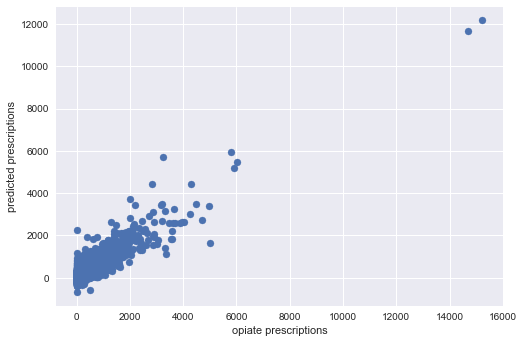

In [305]:
plt.scatter(prescribers.opiates, lr.predict(X_lin))
plt.xlabel("opiate prescriptions")
plt.ylabel("predicted prescriptions")
plt.show()

### (5.) Plotting predicted opiate prescriptions vs True opiate predictions, I can immediately see two outliers on the top right of the graph. Let's plot the residual errors and have a look

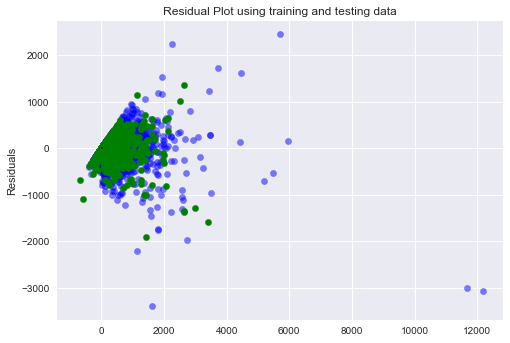

In [306]:
plt.scatter(lr.predict(X_lin_train),lr.predict(X_lin_train)-y_lin_train, c='b', s=40, alpha=0.5)
plt.scatter(lr.predict(X_lin_test),lr.predict(X_lin_test)-y_lin_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(('Residual Plot using training and testing data'))
plt.ylabel('Residuals')
plt.show()

In [382]:
# What are the residuals?
res_sq = (lr.predict(X_lin) - y_lin)**2
res_error = np.sqrt(res_sq)
prescribers['Residual_Error'] = pd.Series(res_error)
prescribers['pred_opiates'] = pd.Series(lr.predict(X_lin))

In [308]:
prescribers.head(2)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,17,6.564653,10.435347
1,1245278100,0,0,0,0,0,0,0,134,0,...,0,0,0,0,0,0,0,362,252.451093,614.451093


###  Let's pull out the top 10 prescribers with the largest Residual Error

In [309]:
outlier_top = prescribers.sort_values('Residual_Error', ascending=False)
outlier_top.head(10)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
5516,1043205305,0,0,0,0,0,0,0,135,0,...,0,0,0,0,0,0,0,5021,3390.188719,0.523134
14265,1831150630,0,55,0,0,0,0,0,300,0,...,0,0,0,0,0,0,0,15234,3063.829844,54.164471
9936,1750364121,0,0,0,0,0,0,0,1905,0,...,0,0,0,0,0,0,0,14674,2992.635738,1.617450
12508,1174512263,0,77,0,0,0,626,166,65,0,...,0,0,0,0,0,0,0,3250,2448.637158,63.822229
12112,1023227576,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2249.344189,40.009047
23810,1346275260,0,0,0,0,0,0,0,14,0,...,0,0,0,0,0,0,0,3345,2202.088758,-33.099245
17082,1962518019,0,0,0,0,0,0,0,52,0,...,0,0,0,0,0,0,0,4687,1960.981267,14.270605
13936,1851370100,0,0,0,0,0,0,11,161,0,...,0,0,0,0,0,0,0,3323,1909.523109,119.322843
3509,1073500260,0,0,0,0,0,0,0,79,0,...,0,0,0,0,0,0,0,3573,1750.780780,20.360610
14953,1568456473,0,0,0,0,0,0,0,236,0,...,0,0,0,0,0,0,0,3547,1733.260050,140.084303


### Maybe the model is being thrown by the prescribers that do not prescribe opiates. Let's try with only opioid prescribers

In [310]:
druggies = prescribers[prescribers.Opioid_Prescriber == 1]
druggies.head(2)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,17,6.564653,10.435347
1,1245278100,0,0,0,0,0,0,0,134,0,...,0,0,0,0,0,0,0,362,252.451093,614.451093


In [311]:
druggies_list = list(druggies.columns)

In [312]:
druggies_list.remove('ACETAMINOPHEN_CODEINE')
druggies_list.remove('TRAMADOL_HCL')
druggies_list.remove('HYDROMORPHONE_HCL')
druggies_list.remove('OXYCODONE_ACETAMINOPHEN')
druggies_list.remove('FENTANYL')
druggies_list.remove('HYDROCODONE_ACETAMINOPHEN')
druggies_list.remove('MORPHINE_SULFATE')
druggies_list.remove('MORPHINE_SULFATE_ER')
druggies_list.remove('Opioid_Prescriber')
druggies_list.remove('OXYCODONE_HCL')
druggies_list.remove('METHADONE_HCL')
druggies_list.remove('OXYCONTIN')
druggies_list.remove('DIPHENOXYLATE_ATROPINE')
druggies_list.remove('opiates')

In [313]:
druggies_list.remove('Residual_Error')
druggies_list.remove('pred_opiates')

In [314]:
Xd = druggies[druggies_list]
yd = druggies.opiates

In [315]:
Xd.head(2)

,NPI,ABILIFY,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,AMITRIPTYLINE_HCL,...,1_Sports Medicine,1_Student in an Organized Health Care Education/Training Program,1_Surgery,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery
0,1710982582,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245278100,0,0,0,0,0,0,134,0,0,...,0,0,0,0,0,0,0,0,0,0


In [316]:
# split into train_test
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, train_size=0.8, random_state=8)

lr.fit(Xd_train, yd_train)

lr.score(Xd_test, yd_test)

0.72605896627576327

### (5.) The linear regression performs less well when used on a dataset containing only opioid prescribers. This could be due to a smaller sample size (The opioid-prescribers-only dataset is half the size of the prescribers dataset)

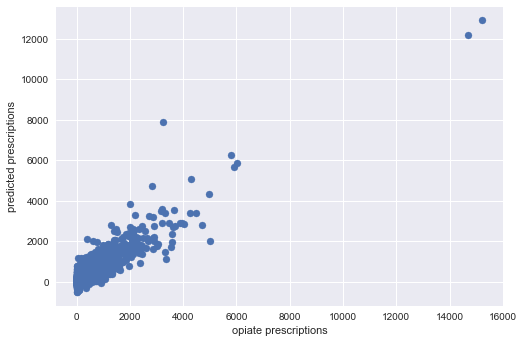

In [317]:
plt.scatter(druggies.opiates, lr.predict(Xd))
plt.xlabel("opiate prescriptions")
plt.ylabel("predicted prescriptions")
plt.show()

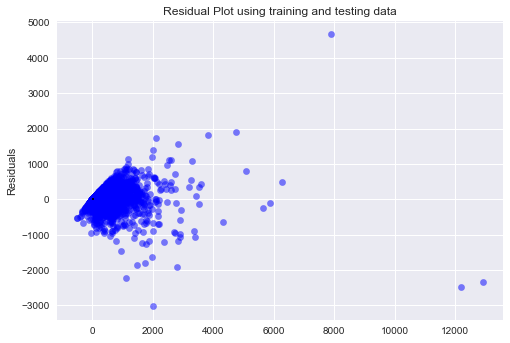

In [318]:
plt.scatter(lr.predict(Xd),lr.predict(Xd)-yd, c='b', s=40, alpha=0.5)
#plt.scatter(lr.predict(X_test),lr.predict(X_test)-y_test, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(('Residual Plot using training and testing data'))
plt.ylabel('Residuals')
plt.show()

### (5.) Let's have a look at the Opioid Prescribers with the largest Residual Errors

In [319]:
outlier_druggies = druggies.sort_values('Residual_Error', ascending=False)
outlier_druggies.head(10)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
5516,1043205305,0,0,0,0,0,0,0,135,0,...,0,0,0,0,0,0,0,5021,3390.188719,0.523134
14265,1831150630,0,55,0,0,0,0,0,300,0,...,0,0,0,0,0,0,0,15234,3063.829844,54.164471
9936,1750364121,0,0,0,0,0,0,0,1905,0,...,0,0,0,0,0,0,0,14674,2992.635738,1.617450
12508,1174512263,0,77,0,0,0,626,166,65,0,...,0,0,0,0,0,0,0,3250,2448.637158,63.822229
23810,1346275260,0,0,0,0,0,0,0,14,0,...,0,0,0,0,0,0,0,3345,2202.088758,-33.099245
17082,1962518019,0,0,0,0,0,0,0,52,0,...,0,0,0,0,0,0,0,4687,1960.981267,14.270605
13936,1851370100,0,0,0,0,0,0,11,161,0,...,0,0,0,0,0,0,0,3323,1909.523109,119.322843
3509,1073500260,0,0,0,0,0,0,0,79,0,...,0,0,0,0,0,0,0,3573,1750.780780,20.360610
14953,1568456473,0,0,0,0,0,0,0,236,0,...,0,0,0,0,0,0,0,3547,1733.260050,140.084303
5660,1760590640,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2003,1729.578066,17.191070


### Most likely candidates for further investigation

### Finally, the chart below shows the average residual error for each specialty. Having a high residual error for Addiction Medicine (where presumably prescribers are using opiates to wean patients off other drugs) and Anesthesiology (where prescribers are far more likely to prescribe opiates for pain management) is expected, but Family Practice shows an unexpectedly high residual error that may warrant further investigation

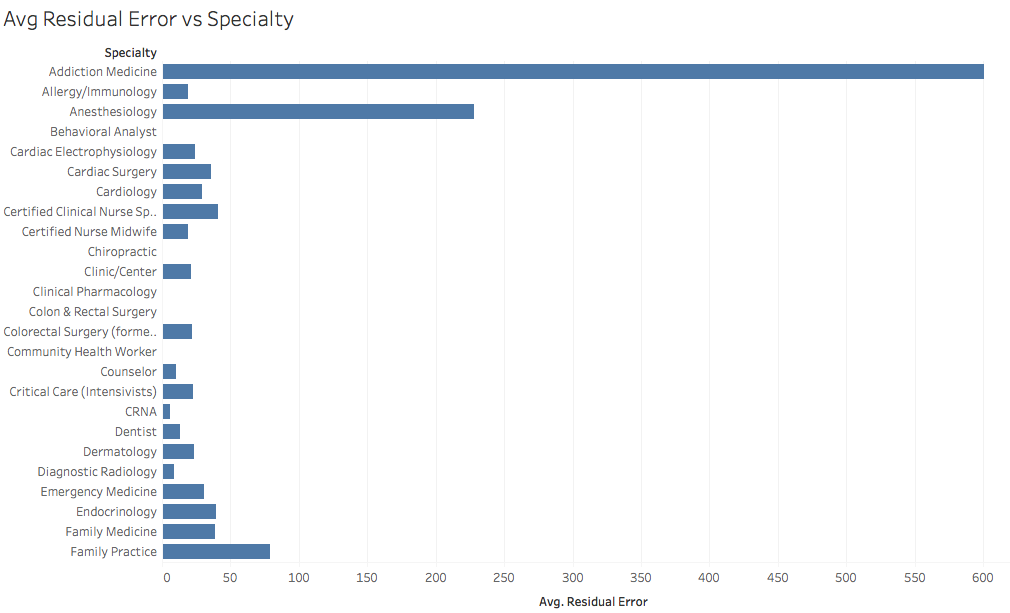

In [320]:
PATH = "/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/"
Image(filename = PATH + "error_specialty.png", width=900, height=900)

# Discussion and Conclusion

## Model Selection:
### In total, I used four model. Linear Regression, Logistic Regression, Decision Trees and PCA. I did not attempt Logistic Regression for Section 4: Opiate Prescription Prediction as my target variable was a continuous, numerical variable.

### Of the three remaining models, I chose linear regression as it had by far the highest score. PCA was not suitable for this data as every non-opiate carried implications for opiate prescription (For example, carisoprodol, a muscle relaxant, might be prescribed together with an opioid to manage pain from chronic cramp.) Similarly, Decision trees did not perform well as the decision to prescribe an opiate is rarely a single path, but is the result of several factors that occur at the same time (E.g: the disorder presented by patient, past medical history, other medications prescribed.)

## Goal achievement:
### While the data was insufficient to correctly identify fraudulent prescription behaviour, I have established that non-opiate prescriptions, as well as state and specialty can be used to predict opiate prescription to an accuracy of almost 80%. I have also identified likely candidates for fraudulent behaviour, and while there is no way to know how accurate the identifications are, it is at least a possible lead.

## Future Work:
### This capstone serves as a proof-of-concept of an analytics approach to curbing prescription opiate abuse. With further data, especially data containing both known 'clean' prescribers and 'fraudulent' prescribers, the linear regression model used in this capstone could be used to identify opiate prescription fraud and hopefully reduce the incidence of opiate abuse, and therefore reduce overdoses.

## Reflection:
### Data cleaning could have been performed more efficiently. It would have been easier if I had simply created one clean dataset for prescribers, opioids and overdoses. Instead, I kept resetting the prescribers dataset as I discovered I dropped columns that I needed for a new model. In effect, I had to clean the data everytime I wanted to try a new model.

##  Last minute analysis for presentation

In [321]:
outlier_druggies = druggies.sort_values('Residual_Error', ascending=False)
outlier_druggies.head(10)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
5516,1043205305,0,0,0,0,0,0,0,135,0,...,0,0,0,0,0,0,0,5021,3390.188719,0.523134
14265,1831150630,0,55,0,0,0,0,0,300,0,...,0,0,0,0,0,0,0,15234,3063.829844,54.164471
9936,1750364121,0,0,0,0,0,0,0,1905,0,...,0,0,0,0,0,0,0,14674,2992.635738,1.617450
12508,1174512263,0,77,0,0,0,626,166,65,0,...,0,0,0,0,0,0,0,3250,2448.637158,63.822229
23810,1346275260,0,0,0,0,0,0,0,14,0,...,0,0,0,0,0,0,0,3345,2202.088758,-33.099245
17082,1962518019,0,0,0,0,0,0,0,52,0,...,0,0,0,0,0,0,0,4687,1960.981267,14.270605
13936,1851370100,0,0,0,0,0,0,11,161,0,...,0,0,0,0,0,0,0,3323,1909.523109,119.322843
3509,1073500260,0,0,0,0,0,0,0,79,0,...,0,0,0,0,0,0,0,3573,1750.780780,20.360610
14953,1568456473,0,0,0,0,0,0,0,236,0,...,0,0,0,0,0,0,0,3547,1733.260050,140.084303
5660,1760590640,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2003,1729.578066,17.191070


In [322]:
outlier_druggies.NPI.values

array([1043205305, 1831150630, 1750364121, ..., 1083753636, 1720095482,
       1831347707])

In [326]:
top_list = list(outlier_druggies.NPI.values)
len(top_list)

14466

In [325]:
top_ten = top_list[0:10]
top_ten

[1043205305,
 1831150630,
 1750364121,
 1174512263,
 1346275260,
 1962518019,
 1851370100,
 1073500260,
 1568456473,
 1760590640]

In [328]:
last_ten = top_list[14456:]
last_ten

[1578763405,
 1407937733,
 1306948492,
 1487660502,
 1689631442,
 1902019441,
 1619088606,
 1083753636,
 1720095482,
 1831347707]

In [332]:
outlier_druggies.tail(10)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
23967,1578763405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16,0.028208,-128.042442
2143,1407937733,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,67,0.028154,12.562621
10056,1306948492,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.025966,240.075258
3895,1487660502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,37,0.022667,722.298730
14745,1689631442,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,0.020515,-3.212950
15685,1902019441,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,43,0.019860,125.424533
1963,1619088606,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,0.001779,10.044191
8804,1083753636,0,0,96,0,0,0,0,70,0,...,0,0,0,0,0,0,0,156,0.000031,12.919407
7327,1720095482,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,24,0.000020,35.848583
16339,1831347707,0,0,27,104,0,746,164,485,33,...,0,0,0,0,0,0,0,135,0.000013,-32.490399


In [333]:
# Will have to reset the prescribers column to pull out state and specialty of these guys
prescribers = pd.read_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/prescriber-info.csv')

In [346]:
prescribers.drop('Credentials',axis=1,inplace=True)
prescribers.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1


In [394]:
prescribers['all_drugs'] = prescribers[drugs].sum(axis=1)

In [396]:
prescribers[prescribers['NPI'].isin(top_ten)]

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Residual_Error,pred_opiates,all_drugs
3509,1073500260,F,WA,Nurse Practitioner,0,0,0,0,0,0,...,0,0,0,0,0,18,1,1617.522112,28.818897,5230
5516,1043205305,M,FL,Anesthesiology,0,0,0,0,0,0,...,0,0,0,0,0,100,1,3020.991476,-1.158371,7799
5660,1760590640,M,PA,Anesthesiology,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1814.232348,77.430384,4607
9936,1750364121,M,LA,Physical Medicine and Rehabilitation,0,0,0,0,0,0,...,0,0,0,0,0,418,1,2481.300725,7.601825,27490
12508,1174512263,M,AZ,Rheumatology,0,77,0,0,0,626,...,0,0,0,0,0,117,1,4658.471258,77.092509,15112
13936,1851370100,M,PA,Physical Medicine and Rehabilitation,0,0,0,0,0,0,...,0,0,0,0,0,61,1,1854.164976,120.335958,4563
14265,1831150630,M,FL,Interventional Pain Management,0,55,0,0,0,0,...,0,0,0,0,0,76,1,2323.005904,-25.677839,21696
14953,1568456473,M,AZ,Pain Management,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1808.786990,64.290633,4360
17082,1962518019,F,OH,Pain Management,0,0,0,0,0,0,...,0,0,0,0,0,50,1,1899.757695,31.927829,7414
23810,1346275260,M,NC,Physical Medicine and Rehabilitation,0,0,0,0,0,0,...,0,15,0,0,0,32,1,2235.321525,-17.835438,4160


In [397]:
top_druggies = druggies.sort_values('opiates', ascending=False)
top_druggies.head(10)

,NPI,ABILIFY,ACETAMINOPHEN_CODEINE,ACYCLOVIR,ADVAIR_DISKUS,AGGRENOX,ALENDRONATE_SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE_HCL,...,1_Surgical Oncology,1_Thoracic Surgery,1_Thoracic Surgery (Cardiothoracic Vascular Surgery),1_Unknown Physician Specialty Code,1_Unknown Supplier/Provider,1_Urology,1_Vascular Surgery,opiates,Residual_Error,pred_opiates
14265,1831150630,0,55,0,0,0,0,0,300,0,...,0,0,0,0,0,0,0,15234,3063.829844,54.164471
9936,1750364121,0,0,0,0,0,0,0,1905,0,...,0,0,0,0,0,0,0,14674,2992.635738,1.617450
17624,1225069065,0,20,0,0,0,0,0,20,0,...,0,0,0,0,0,0,0,6003,526.614267,-0.497363
23823,1053392571,0,0,0,0,0,0,0,31,0,...,0,0,0,0,0,0,0,5890,695.573354,6.756939
14389,1215199609,0,31,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5793,151.084323,8.346115
5516,1043205305,0,0,0,0,0,0,0,135,0,...,0,0,0,0,0,0,0,5021,3390.188719,0.523134
10367,1124098603,34,38,60,88,14,69,310,117,56,...,0,0,0,0,0,0,0,4974,1573.059659,-7.289913
17082,1962518019,0,0,0,0,0,0,0,52,0,...,0,0,0,0,0,0,0,4687,1960.981267,14.270605
17685,1427075506,11,0,0,0,0,0,0,560,0,...,0,0,0,0,0,0,0,4473,964.915234,-2.657240
1090,1982823225,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4283,143.670953,13.980885


In [398]:
druggies.opiates.describe()

count    14466.000000
mean       147.702682
std        359.516010
min          0.000000
25%         15.000000
50%         44.000000
75%        137.000000
max      15234.000000
Name: opiates, dtype: float64

In [402]:
druggies_res = druggies[['NPI','opiates','Residual_Error','pred_opiates',]]
druggies_res.head(10)

,NPI,opiates,Residual_Error,pred_opiates
0,1710982582,17,6.564653,10.435347
1,1245278100,362,252.451093,614.451093
3,1669567541,559,448.966073,110.033927
4,1679650949,66,19.620886,85.620886
5,1548580897,25,14.607370,39.607370
6,1437192002,90,70.836562,19.163438
9,1821106832,64,60.564857,124.564857
11,1659334472,17,22.777111,35.793359
12,1144205303,247,211.206641,6.199404
14,1952598419,166,11.420615,45.588659


In [403]:
new_druggies = prescribers[prescribers['Opioid.Prescriber'] == 1]
new_druggies.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Residual_Error,pred_opiates,all_drugs
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.556549,15.443451,29
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,35,1,237.630662,599.630662,1418


In [404]:
druggies_spec = new_druggies[['NPI','State','Specialty','all_drugs']]
druggies_spec.head(2)

,NPI,State,Specialty,all_drugs
0,1710982582,TX,Dentist,29
1,1245278100,AL,General Surgery,1418


In [405]:
find_druggies = pd.merge(druggies_spec, druggies_res, on='NPI', how='inner')
find_druggies.head(2)

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
0,1710982582,TX,Dentist,29,17,6.564653,10.435347
1,1245278100,AL,General Surgery,1418,362,252.451093,614.451093


In [406]:
find_druggies.sort_values('Residual_Error', ascending=False)

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
3184,1043205305,FL,Anesthesiology,7799,5021,3390.188719,0.523134
8285,1831150630,FL,Interventional Pain Management,21696,15234,3063.829844,54.164471
5761,1750364121,LA,Physical Medicine and Rehabilitation,27490,14674,2992.635738,1.617450
7282,1174512263,AZ,Rheumatology,15112,3250,2448.637158,63.822229
13772,1346275260,NC,Physical Medicine and Rehabilitation,4160,3345,2202.088758,-33.099245
9871,1962518019,OH,Pain Management,7414,4687,1960.981267,14.270605
8108,1851370100,PA,Physical Medicine and Rehabilitation,4563,3323,1909.523109,119.322843
2003,1073500260,WA,Nurse Practitioner,5230,3573,1750.780780,20.360610
8651,1568456473,AZ,Pain Management,4360,3547,1733.260050,140.084303
3262,1760590640,PA,Anesthesiology,4607,2003,1729.578066,17.191070


In [407]:
nurses = find_druggies[find_druggies['Specialty'] == 'Nurse Practitioner']
top_nurses = nurses.sort_values('Residual_Error', ascending=False)
top_nurses.head()

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
2003,1073500260,WA,Nurse Practitioner,5230,3573,1750.780780,20.360610
9345,1881610525,AZ,Nurse Practitioner,4482,3033,1445.759972,14.277198
2446,1821351438,NC,Nurse Practitioner,6299,3893,1311.101312,27.433363
1249,1801145230,TN,Nurse Practitioner,3495,2372,1006.635845,3.155665
14149,1588653695,IN,Nurse Practitioner,2126,1332,993.310178,26.629421


In [413]:
last_nurses = nurses.sort_values('Residual_Error', ascending=True)
last_nurses.head()

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
12227,1477510352,FL,Nurse Practitioner,526,13,0.111025,14.407173
8753,1578566113,PA,Nurse Practitioner,406,20,0.148877,265.326936
10649,1831139070,NY,Nurse Practitioner,3578,193,0.229494,-10.793795
13151,1447567128,OH,Nurse Practitioner,17,17,0.266696,-18.976579
4913,1780917443,MS,Nurse Practitioner,547,0,0.271640,8.154095


In [409]:
nurses.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/nurses.csv')

In [410]:
top_nurses.to_csv('/Users/lohyenwei/Documents/Data_Science/Capstone/GitRepo/capstone_yen/Opioids/top_nurses.csv')

In [411]:
nurses.opiates.describe()

count    1343.000000
mean      129.632167
std       290.885298
min         0.000000
25%        15.000000
50%        41.000000
75%       114.000000
max      3893.000000
Name: opiates, dtype: float64

In [412]:
nurses.Residual_Error.describe()

count    1343.000000
mean       70.365659
std       132.448309
min         0.111025
25%        12.119381
50%        29.554614
75%        74.118102
max      1750.780780
Name: Residual_Error, dtype: float64

In [391]:
prescribers.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Residual_Error,pred_opiates
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.556549,15.443451
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,0,35,1,237.630662,599.630662


In [392]:
drugs = list(prescribers.columns)

In [393]:
drugs.remove('NPI')
drugs.remove('Opioid.Prescriber')
drugs.remove('Residual_Error')
drugs.remove('pred_opiates')

In [395]:
prescribers.head(2)

,NPI,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Residual_Error,pred_opiates,all_drugs
0,1710982582,M,TX,Dentist,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1.556549,15.443451,29
1,1245278100,F,AL,General Surgery,0,0,0,0,0,0,...,0,0,0,0,0,35,1,237.630662,599.630662,1418


In [419]:
fam_med = find_druggies[find_druggies['Specialty'] == 'Family Practice']
top_fam = fam_med.sort_values('Residual_Error', ascending=False)
top_fam.head()

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
6012,1124098603,MS,Family Practice,38060,4974,1573.059659,-7.289913
2266,1285695866,KY,Family Practice,29144,2434,1003.998012,13.100238
7697,1104824119,PA,Family Practice,12854,2021,929.941965,95.307016
11570,1992757645,MI,Family Practice,2932,1027,795.092345,-104.399268
14000,1154313005,TX,Family Practice,11655,816,782.452719,-4.463568


In [420]:
last_fam = fam_med.sort_values('Residual_Error', ascending=True)
last_fam.head()

,NPI,State,Specialty,all_drugs,opiates,Residual_Error,pred_opiates
8397,1174500482,KY,Family Practice,954,0,0.028734,26.176459
12785,1588740575,KY,Family Practice,6288,241,0.078937,296.246230
3621,1487637666,ID,Family Practice,1939,190,0.083419,7.857131
1977,1790709186,CA,Family Practice,696,18,0.145051,30.501412
5619,1669461687,FL,Family Practice,3514,38,0.161226,150.183529


In [421]:
fam_med.opiates.describe()

count    2619.000000
mean      224.103856
std       309.223016
min         0.000000
25%        31.000000
50%       111.000000
75%       300.000000
max      4974.000000
Name: opiates, dtype: float64

In [422]:
fam_med.Residual_Error.describe()

count    2619.000000
mean       86.502014
std       109.898406
min         0.028734
25%        17.000269
50%        47.819902
75%       114.779557
max      1573.059659
Name: Residual_Error, dtype: float64

In [ ]:
# plot distribution of residual error for each specialty?